In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler 
from scipy import stats
from scipy.stats import norm,skew
import warnings
from sklearn.preprocessing import RobustScaler
warnings.filterwarnings("ignore")
%matplotlib inline
# MinMaxScaler用於數據的歸一化
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential  
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import r2_score

# 讀取數據

def create_timestamp(data):
    # 將"Date"和"Time"合併成時間戳記並設置為索引
    data['Timestamp'] = pd.to_datetime(data['Date'] + ' ' + data['Time'])
    data = data.set_index('Timestamp')
    return data

data_path = r'C:\Users\rex\Desktop\水位預測\3\1510H071.csv'   
data = pd.read_csv(data_path)

# 使用函數創建時間戳
data = create_timestamp(data)
print (data)
data.head(5)



                           Date   Time  1510H071 Water Level  19606 Rainfall
Timestamp                                                                   
2020-01-01 00:00:00    2020/1/1  00:00                 20.58        0.000000
2020-01-01 01:00:00    2020/1/1  01:00                 20.80        0.000000
2020-01-01 02:00:00    2020/1/1  02:00                 20.81        0.000000
2020-01-01 03:00:00    2020/1/1  03:00                 20.80        0.000000
2020-01-01 04:00:00    2020/1/1  04:00                 20.79        0.000000
...                         ...    ...                   ...             ...
2022-12-31 19:00:00  2022/12/31  19:00                 19.22        0.000000
2022-12-31 20:00:00  2022/12/31  20:00                 19.22        0.065994
2022-12-31 21:00:00  2022/12/31  21:00                 19.21        0.057345
2022-12-31 22:00:00  2022/12/31  22:00                 19.21        0.000000
2022-12-31 23:00:00  2022/12/31  23:00                 19.21        0.065994

,Date,Time,1510H071 Water Level,19606 Rainfall
Timestamp,,,,
2020-01-01 00:00:00,2020/1/1,00:00,20.58,0.0
2020-01-01 01:00:00,2020/1/1,01:00,20.80,0.0
2020-01-01 02:00:00,2020/1/1,02:00,20.81,0.0
2020-01-01 03:00:00,2020/1/1,03:00,20.80,0.0
2020-01-01 04:00:00,2020/1/1,04:00,20.79,0.0


In [ ]:
output_excel_file = r"C:\Users\rex\Desktop\水位預測\2\缺失值.xlsx"

rows_with_missing_values = data[data.isnull().any(axis=1)]

rows_with_missing_values.to_excel(output_excel_file, index=False)

print("已成功。")

In [ ]:
data.info()

In [2]:
data['1510H071 Water Level'] = data['1510H071 Water Level'].round(1)

# 列出所有要增加特徵的欄位名稱
columns_to_expand = [
    # "1510H084 Water Level",
    # "1510H076 Water Level",
    "1510H071 Water Level",
    # "1510H057 Water Level",
    # "19774 Rainfall"
    # "20016 Rainfall",
    "19606 Rainfall"
    # "19335 Rainfall"
]

# 增加_T-1到_T-48的特徵
for col in columns_to_expand:
    for t in range(1, 73):
        new_col_name = f"{col}_T-{t}"
        data[new_col_name] = data[col].shift(t)
# 建立滑動窗口的平均水位和標準差
window_size = 48 # 48小時

# for station in ["1510H084", "1510H076", "1510H071", "1510H057"]:


for station in ["1510H071"]:    
    col = f"{station} Water Level"
    data[f"{col}_rolling_mean"] = data[col].rolling(window_size).mean()     #過去48小時平均水位
    data[f"{col}_rolling_std"] = data[col].rolling(window_size).std()       #過去48小時水位標準差


# data.to_excel(r'C:\Users\rex\Desktop\水位預測\2\總資料新增特徵.xlsx', index=False)

# 對每個站點的水位差分
# for station in ["1510H084", "1510H076", "1510H071", "1510H057"]:

for station in ["1510H071"]:    
    col = f"{station} Water Level"
    data[f"{col}_diff"] = data[col].diff()                                  #前一小時水位差


data

,Date,Time,1510H071 Water Level,19606 Rainfall,1510H071 Water Level_T-1,1510H071 Water Level_T-2,1510H071 Water Level_T-3,1510H071 Water Level_T-4,1510H071 Water Level_T-5,1510H071 Water Level_T-6,...,19606 Rainfall_T-66,19606 Rainfall_T-67,19606 Rainfall_T-68,19606 Rainfall_T-69,19606 Rainfall_T-70,19606 Rainfall_T-71,19606 Rainfall_T-72,1510H071 Water Level_rolling_mean,1510H071 Water Level_rolling_std,1510H071 Water Level_diff
Timestamp,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,2020/1/1,00:00,20.6,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 01:00:00,2020/1/1,01:00,20.8,0.000000,20.6,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.2
2020-01-01 02:00:00,2020/1/1,02:00,20.8,0.000000,20.8,20.6,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2020-01-01 03:00:00,2020/1/1,03:00,20.8,0.000000,20.8,20.8,20.6,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2020-01-01 04:00:00,2020/1/1,04:00,20.8,0.000000,20.8,20.8,20.8,20.6,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,2022/12/31,19:00,19.2,0.000000,19.2,19.2,19.2,19.2,19.2,19.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.2,0.0,0.0
2022-12-31 20:00:00,2022/12/31,20:00,19.2,0.065994,19.2,19.2,19.2,19.2,19.2,19.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.2,0.0,0.0
2022-12-31 21:00:00,2022/12/31,21:00,19.2,0.057345,19.2,19.2,19.2,19.2,19.2,19.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.2,0.0,0.0


In [3]:
# 增加T+1到T+48的雨量
for station in [
    "19606 Rainfall"
    # "20016 Rainfall",
    # "19335 Rainfall",
    # "19606 Rainfall"
    ]:
    col = f"{station}"
    for t in range(1, 73):
        future_col_name = f"{col}_T+{t}"
        data[future_col_name] = data[col].shift(-t)

# 刪除包含NaN的行
data = data.dropna()
data

,Date,Time,1510H071 Water Level,19606 Rainfall,1510H071 Water Level_T-1,1510H071 Water Level_T-2,1510H071 Water Level_T-3,1510H071 Water Level_T-4,1510H071 Water Level_T-5,1510H071 Water Level_T-6,...,19606 Rainfall_T+63,19606 Rainfall_T+64,19606 Rainfall_T+65,19606 Rainfall_T+66,19606 Rainfall_T+67,19606 Rainfall_T+68,19606 Rainfall_T+69,19606 Rainfall_T+70,19606 Rainfall_T+71,19606 Rainfall_T+72
Timestamp,,,,,,,,,,,,,,,,,,,,,
2020-01-04 00:00:00,2020/1/4,00:00,20.4,0.0,20.5,20.5,20.5,20.5,20.5,20.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
2020-01-04 01:00:00,2020/1/4,01:00,20.6,0.0,20.4,20.5,20.5,20.5,20.5,20.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
2020-01-04 02:00:00,2020/1/4,02:00,20.6,0.0,20.6,20.4,20.5,20.5,20.5,20.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
2020-01-04 03:00:00,2020/1/4,03:00,20.6,0.0,20.6,20.6,20.4,20.5,20.5,20.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
2020-01-04 04:00:00,2020/1/4,04:00,20.6,0.0,20.6,20.6,20.6,20.4,20.5,20.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-28 19:00:00,2022/12/28,19:00,19.2,0.0,19.2,19.2,19.2,19.2,19.2,19.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
2022-12-28 20:00:00,2022/12/28,20:00,19.2,0.0,19.2,19.2,19.2,19.2,19.2,19.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.065994
2022-12-28 21:00:00,2022/12/28,21:00,19.2,0.0,19.2,19.2,19.2,19.2,19.2,19.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.065994,0.057345


In [ ]:
import sys
print(sys.executable)

In [ ]:
#看數據維度
print(data.shape)
#看數據訊息
data.info()

In [4]:
# 刪除不必要的列
data = data.drop(['Date', 'Time'], axis=1)  


In [ ]:
# k = 10  # 選擇最相關的特徵數

# # 計算相關性
# corrmat = data.corr()

# for t in range(48, 49):
#     target = f"1510H084 Water Level_T+{t}"  # 將目標變數更改為相應的 T+n

#     # 獲取與目標變數相關性最高的k個特徵
#     topk = corrmat.nlargest(k, target)[target].index

#     # 計算這些特徵之間的相關性
#     cm = np.corrcoef(data[topk].values.T)

#     # 繪製熱圖
#     fig, ax = plt.subplots(figsize=(10, 10))
#     sns.set(font_scale=1.25)
#     hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=topk.values, xticklabels=topk.values)
#     plt.title(f"Correlations for {target}")
#     plt.show()


In [ ]:
# # 分析目標變量的分布，計算均值與標準差
# targets = ["1510H084 Water Level", "1510H076 Water Level", "1510H071 Water Level", "1510H057 Water Level"]

# fig, axs = plt.subplots(2, 4, figsize=(24, 12))  # 創建一個包含8個子圖的圖形窗口

# for i, target in enumerate(targets):
    
#     # 繪製概率密度函數和核密度估計的圖
#     sns.distplot(data[target], fit=norm, ax=axs[0, i])   # 將圖繪製在適當的子圖上
    
#     (mu, sigma) = norm.fit(data[target])   # 對變量進行最大似然估計
#     print('\nmu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
    
#     axs[0, i].legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
#     axs[0, i].set_ylabel('Frequency')
#     axs[0, i].set_title('{} distribution'.format(target))
    
#     # 繪製概率圖
#     stats.probplot(data[target], plot=axs[1, i])   # 將圖繪製在適當的子圖上

# plt.tight_layout()  # 自動調整子圖的佈局，使之填滿整個圖形窗口
# plt.show()


In [ ]:
# targets = ['1510H084 Water Level', '1510H076 Water Level', '1510H071 Water Level', '1510H057 Water Level']

# # 僅保留數據集中的數值型列
# numeric_data = data.select_dtypes(include=[np.number])

# k = 15
# corrmat = numeric_data.corr()
# # 選擇與目標變數相關性最高的特徵
# top_corr_features = []
# for target in targets:
#     top_corr = corrmat[target].nlargest(k).index
#     top_corr_features.extend(top_corr)

# # 移除重複的特徵
# top_corr_features = list(dict.fromkeys(top_corr_features))

# # 將目標變數移到列表前端
# for target in reversed(targets):
#     top_corr_features.remove(target)
#     top_corr_features.insert(0, target)

# cm = np.corrcoef(numeric_data[top_corr_features].values.T)

# fig, ax = plt.subplots(figsize=(12, 12))
# sns.set(font_scale=1.25)
# hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.3f', annot_kws={'size':10},
#             yticklabels=top_corr_features, xticklabels=top_corr_features, cmap='RdYlBu_r', vmin=-0.2, vmax=1.0)
# plt.title(f"Top {k} Correlations with Targets")
# plt.show()

In [ ]:
print(data.columns)

In [5]:
# 列出目標水位列
target_columns = [
    # "1510H057 Water Level",
    "1510H071 Water Level"
    # "1510H076 Water Level",
    # "1510H084 Water Level"
]
# 1. 增加目標列：T+1到T+48的目標水位
for target_col in target_columns:
    for t in range(1, 289):
        target = f'{target_col}_target_{t}'
        data[target] = data[target_col].shift(-t)
        
# 移除含有 NaN 的行
data = data.dropna()


In [ ]:
for col in target_columns:
    print(f"{col}: {data[col].min()} - {data[col].max()}")

In [ ]:
import pandas as pd

# 建立特征名稱與描述之間的對應
feature_description = {}

# 滾動平均和標準差的描述
for station in ["1510H076"]:    
    col = f"{station} Water Level"
    feature_description[f"{col}_rolling_mean"] = f"{col} 過去48小時的滾動平均"
    feature_description[f"{col}_rolling_std"] = f"{col} 過去48小時的滾動標準差"

# 水位差分描述
for station in ["1510H076"]:    
    col = f"{station} Water Level"
    feature_description[f"{col}_diff"] = f"{col} 與前一小時的水位差分"

# 增加T+1到T+72的雨量描述
for station in ["20016 Rainfall"]:
    col = f"{station}"
    for t in range(1, 73):
        future_col_name = f"{col}_forecast_{t}"
        feature_description[future_col_name] = f"{col} 在時間點 T+{t} 的預測雨量"

# 目標列描述
for target_col in target_columns:
    for t in range(1, 289):
        target = f'{target_col}_target_{t}'
        feature_description[target] = f"{target_col} 在時間點 T+{t} 的目標水位"

# 轉換成DataFrame並保存為Excel
df_descriptions = pd.DataFrame(list(feature_description.items()), columns=['Feature Name', 'Description'])
df_descriptions.to_excel(r'C:\Users\rex\Desktop\水位預測\3\084feature_descriptions.xlsx', index=False)


In [6]:
# 歸一化數據 X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0)) 最小最大歸一化
scalers = {}
for i in data.columns:
    scaler = MinMaxScaler(feature_range=(0, 1))
    s_s = scaler.fit_transform(data[i].values.reshape(-1,1))
    s_s = np.reshape(s_s, len(s_s))
    scalers['scaler_'+ i] = scaler
    data[i] = s_s

In [ ]:
from joblib import dump

# 儲存 scalers
dump(scalers, 'scalers p2.joblib')

In [7]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from scipy.stats import uniform, randint
import lightgbm as lgb

# 切分數據為訓練和測試集
X = data.drop([f'1510H084 Water Level_target_{i}' for i in range(1, 289)], axis=1)  # 特徵
y = data[f'1510H084 Water Level_target_1']  # 目標變數

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # 切分訓練和測試集

# 定義參數的範圍
param_dist = {
    'objective': ['regression'],  # 回歸問題
    'num_leaves': randint(24, 35),  # 樹的最大葉子數
    'learning_rate': uniform(0.01, 0.03),  # 學習率
    'n_estimators': randint(650, 760),  # 樹的數量
    'max_bin': randint(30, 50),  # 最大bin數量
    'subsample': uniform(0.7, 0.85),  # 子樣本比例
    'subsample_freq': randint(2, 5),  # 子樣本選擇頻率
    'colsample_bytree': uniform(0.7, 0.85),  # 每棵樹使用特徵的比例
    'min_child_samples': randint(4, 7),  # 每個葉子節點上的最小樣本數
    'min_child_weight': randint(10, 13),  # 最小子節點權重和
    'device': ['gpu'],  # 使用GPU進行計算
}

lgb_estimator = lgb.LGBMRegressor(silent=True, verbose=0)  # 定義LightGBM模型

# 隨機搜索參數
rsearch = RandomizedSearchCV(estimator=lgb_estimator,
                             param_distributions=param_dist,
                             n_iter=100,  # 嘗試的參數組合次數
                             cv=5,  # 交叉驗證的折數
                             verbose=1,
                             n_jobs=5,  # 使用的CPU核心數
                             random_state=42)

rsearch.fit(X_train, y_train)  # 在訓練數據上進行隨機搜索

# 輸出最佳參數和分數
print('Best parameters found by random search are', rsearch.best_params_)
print('Best score found by random search is', rsearch.best_score_)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


KeyboardInterrupt: 

In [ ]:
# 使用最佳參數訓練模型
best_estimator = rsearch.best_estimator_

# 使用測試集評估模型性能
y_pred = best_estimator.predict(X_test)

# 你可以使用不同的評估指標來評估性能，例如MSE或R^2
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Test MSE:", mse)
print("Test R^2:", r2)


In [7]:
#導入
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold,cross_val_score,train_test_split,cross_val_predict
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from math import sqrt
from tensorflow.keras.layers import TimeDistributed, Flatten
from lightgbm import early_stopping


In [8]:
#定義滑動窗口，窗口由 time_steps 參數控制
def create_dataset(X, y, time_steps=1):         #   X 和 y，分別代表特徵和目標變量。time_steps 參數則表示滑動窗口的大小。
    Xs, ys = [], []                             #   創建兩個空的列表 Xs 和 ys
    for i in range(len(X) - time_steps):        #從第一個時間點開始，一直到可以形成最後一個完整的滑動窗口的位置。
        v = X.iloc[i:(i + time_steps)].values   #選取一個時間窗口內的數據。第 i 時間點開始，包含了接下來的 time_steps 個時間點的數據。
        Xs.append(v)                            #將這個時間窗口的數據添加到 Xs 列表中。
        ys.append(y.iloc[i + time_steps])       #將目標變量在該窗口之後的第一個值添加到 ys 列表中。這個值是與前面時間窗口的 X 對應的 y。
    return np.array(Xs), np.array(ys)           #將 Xs 和 ys 轉換為 numpy 數組並返回。

In [9]:
# MAPE計算函數
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [10]:
import random
from joblib import dump
#隨機種子
seed_value = 42             # 種子值
random.seed(seed_value)     # random 模組設定隨機數生成器的種子
np.random.seed(seed_value)  # NumPy 模組設定隨機數生成器的種子

# 切分數據集，前80%的數據作為訓練集，剩下的20%作為測試集。
train_size = int((len(data) *0.8))
train_data = data[:train_size]
test_data = data[train_size:]

#然後將訓練集中最後的10%作為驗證集。
val_size = int(len(train_data) *0.1)
train_data, val_data = train_data[:-val_size], train_data[-val_size:]

#定義時間步長
time_steps = 48

#副本的創建
train_temp = train_data.copy()
val_temp = val_data.copy()
test_temp = test_data.copy()


In [ ]:
# # 列出目標水位列
# target_columns = [
#     "1510H084 Water Level",
#     "1510H076 Water Level",
#     "1510H071 Water Level",
#     "1510H057 Water Level"
# ]

# # 1. 增加目標列：T+1到T+48的目標水位
# for target_col in target_columns:
#     for t in range(1, 49):
#         target = f'{target_col}_target_{t}'
#         data[target] = data[target_col].shift(-t)

# # 移除含有 NaN 的行
# data = data.dropna()

# # 3. 切分數據集
# train_size = int(len(data) * 0.8)
# train_data = data[:train_size]
# test_data = data[train_size:]

# # 進一步切分訓練集和驗證集
# val_size = int(len(train_data) * 0.1)
# train_data, val_data = train_data[:-val_size], train_data[-val_size:]

# # 定義時間步長
# time_steps = 48

# # 確保 'models' 資料夾存在
# if not os.path.exists('models'):
#     os.makedirs('models')
    
# # 對於每一個目標，進行一次以上的過程
# for target_col in target_columns:
#     for t in range(1, 49):
#         target = f'{target_col}_target_{t}'
        
#         # 創建並適應scaler
#         scaler = MinMaxScaler(feature_range=(0, 1))
#         scaler = scaler.fit(train_data[[target]])

#         # 將scaler存儲在字典中
#         scalers['scaler_' + target] = scaler

#         # 將目標列轉換為縮放的值
#         train_data[target] = scaler.transform(train_data[[target]])
#         if target in val_data.columns: # 確保驗證集有這個目標列
#             val_data[target] = scaler.transform(val_data[[target]])
#         if target in test_data.columns: # 確保測試集有這個目標列
#             test_data[target] = scaler.transform(test_data[[target]])

#         # 切分訓練集、驗證集與測試集
#         X_train, y_train = create_dataset(train_data, train_data[target], time_steps)
#         X_val, y_val = create_dataset(val_data, val_data[target], time_steps)
#         X_test, y_test = create_dataset(test_data, test_data[target], time_steps)
        
#         # 4. 訓練模型並進行預測
#         model = Sequential()
#         model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
#         model.add(TimeDistributed(Flatten()))
#         model.add(LSTM(50, activation='tanh'))
#         model.add(Dense(1))                 # 輸出層的神經元數量為1，因為是針對單個目標變量進行預測
#         model.compile(optimizer='adam', loss='mse')
#         early_stopping = EarlyStopping(monitor='val_loss', patience=2)
#         checkpoint = ModelCheckpoint(
#             'models/model-{epoch:03d}.h5',  # 目標文件的名稱格式，儲存到 'models' 資料夾下
#             monitor='val_loss',             # 要監視的值
#             verbose=0,                      # 日誌模式
#             save_best_only=True,            # 是否只保存最好的epoch
#             mode='auto'                     # 如果monitor選項是'val_loss'，那麼模式應該是'min'。如果monitor選項是'val_acc'，那麼模式應該是'max'
#         )
#         model.fit(
#             X_train, y_train,
#             epochs=15,
#             batch_size=32,
#             validation_data=(X_val, y_val),
#             verbose=1,
#             shuffle=False,
#             callbacks=[early_stopping, checkpoint]  # 添加回調列表
#         )
#         y_pred = model.predict(X_test)
        
#         # 5. 評估模型
#         y_pred = scalers['scaler_' + target].inverse_transform(y_pred).flatten()
#         y_test_reshaped = y_test.reshape(-1, 1)  # 重塑y_test为2D数组
#         y_test = scalers['scaler_' + target].inverse_transform(y_test_reshaped).flatten()
#         r2 = r2_score(y_test, y_pred)
#         mse = mean_squared_error(y_test, y_pred)
#         mae = mean_absolute_error(y_test, y_pred)
#         print(f'Target: {target}, r2: {r2}, mse: {mse}, mae: {mae}')

Timestamp: 2022-12-16 23:00:00, Target: 1510H084 Water Level_target_86, r2: -0.5780301074323899, mse: 0.9372363614167245, mae: 0.8142034779886502, rmse: 0.9681096846002133, mape: 0.5624740321301293
Timestamp: 2022-12-16 23:00:00, Target: 1510H084 Water Level_target_87, r2: -0.5772811054130118, mse: 0.936721691881936, mae: 0.8137459525935022, rmse: 0.967843836515962, mape: 0.5621589087902973
Timestamp: 2022-12-16 23:00:00, Target: 1510H084 Water Level_target_88, r2: -0.5810682699176226, mse: 0.9388519490421554, mae: 0.8148390419618415, rmse: 0.9689437285220207, mape: 0.562910868566509
Timestamp: 2022-12-16 23:00:00, Target: 1510H084 Water Level_target_89, r2: -0.5808350110667695, mse: 0.9386427066438767, mae: 0.8143225839540195, rmse: 0.9688357480212405, mape: 0.5625538750869089
Timestamp: 2022-12-16 23:00:00, Target: 1510H084 Water Level_target_90, r2: -0.5773703579829299, mse: 0.9365145557210529, mae: 0.8131196833914854, rmse: 0.967736821517634, mape: 0.5617195156651393
Timestamp: 202

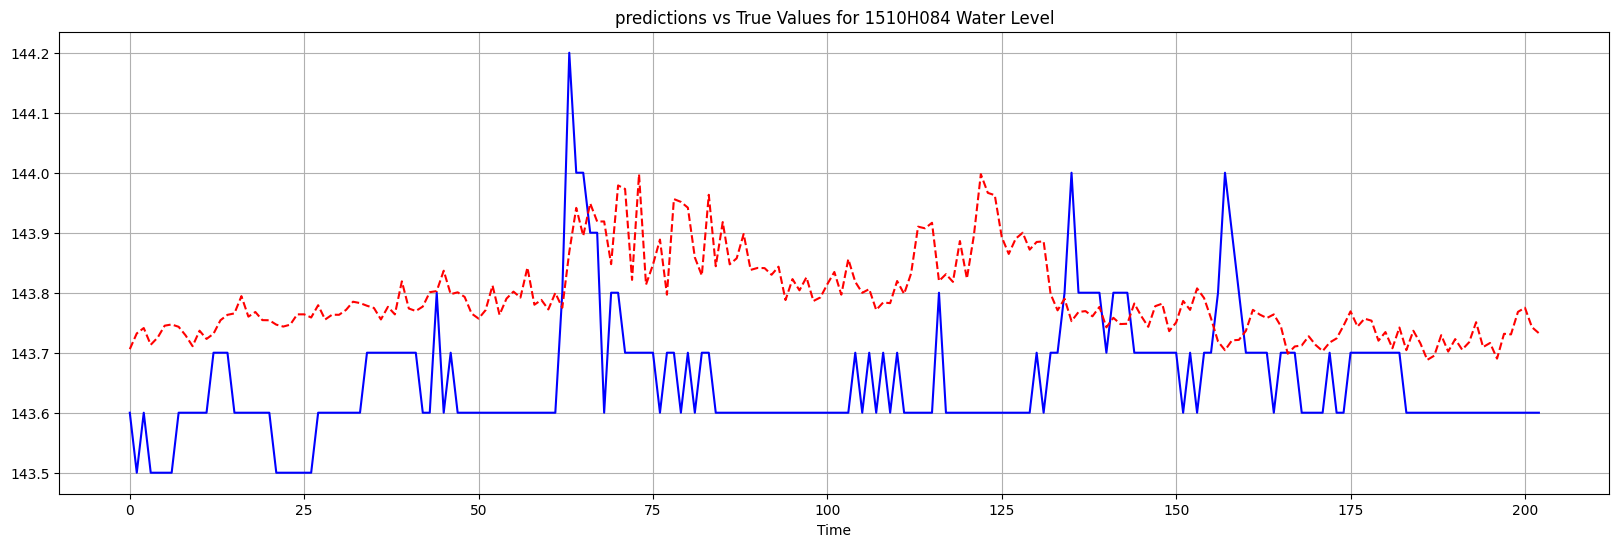

In [11]:
# T+1~T+48訓練並繪圖<<<<
import random
from joblib import dump

#隨機種子
seed_value = 42             # 種子值
random.seed(seed_value)     # random 模組設定隨機數生成器的種子
np.random.seed(seed_value)  # NumPy 模組設定隨機數生成器的種子

# 切分數據集，前80%的數據作為訓練集，剩下的20%作為測試集。
train_size = int((len(data) *0.8))
train_data = data[:train_size]
test_data = data[train_size:]

#然後將訓練集中最後的10%作為驗證集。
val_size = int(len(train_data) *0.1)
train_data, val_data = train_data[:-val_size], train_data[-val_size:]

#定義時間步長
time_steps = 48

#副本的創建
train_temp = train_data.copy()
val_temp = val_data.copy()
test_temp = test_data.copy()

# 檢查 "water_model1" 資料夾存在
if not os.path.exists("water_model5"):
    os.makedirs("water_model5")
    
def model_exists(target_col, t):
    return os.path.exists(f"water_model5/model_{target_col}_t{t}.joblib")
    
# 進行模型訓練、預測和評估
for target_col in target_columns:
    plt.figure(figsize=(20, 6))
    
    true_values = [] # 儲存真實值
    predictions = [] # 儲存預測值
    test_temp = test_data.copy()
    original_feature_names = train_temp.drop(columns=[f'{target_col}_target_{i}' for i in range(1, 289)]).columns.tolist()
    original_feature_names = [f"{name}_t-{i}" for i in range(time_steps) for name in original_feature_names]
    original_feature_names = [name.replace(" ", "_") for name in original_feature_names]
    
    for t in range(1, 289):
        timestamp = test_temp.index[-1]
        target = f'{target_col}_target_{t}'
        if model_exists(target_col, t):
            continue
        
        # 如果t不等於1，更新test_temp中的特定列值為上一個時刻的預測值
        if t > 1 and predictions:  
            # 將 T+1 的預測值設置為 T+2 的輸入
            test_temp.loc[timestamp, target_col] = predictions[-1]
                
        # 獲取測試集該時刻的時間戳記
        timestamp = test_temp.index[-1]
        
        target = f"{target_col}_target_{t}"
        
        
        # 切分訓練集、驗證集與測試集
        X_train, y_train = create_dataset(train_temp.drop(columns=[f'{target_col}_target_{i}' for i in range(1, 289)]), train_temp[target], time_steps)
        X_val, y_val = create_dataset(val_temp.drop(columns=[f'{target_col}_target_{i}' for i in range(1, 289)]), train_temp[target], time_steps)
        X_test, y_test = create_dataset(test_temp.drop(columns=[f'{target_col}_target_{i}' for i in range(1, 289)]), train_temp[target], time_steps)
        
        # 重塑 X_train, X_val 和 X_test
        X_train = X_train.reshape((X_train.shape[0], -1))
        X_val = X_val.reshape((X_val.shape[0], -1))
        X_test = X_test.reshape((X_test.shape[0], -1))
        
        # 訓練模型並進行預測
        model = lgb.LGBMRegressor(
            objective='regression',            # 目標函數，這裡是回歸問題
            num_leaves=25,                     # 樹中葉子的最大數量
            learning_rate=0.01212822750999789, # 學習率
            n_estimators=736,                  # 弱學習器或者說決策樹的數量
            max_bin=43,                        # 數據分箱的最大數量，控制數據劃分的總數量 LightGBM 將連續的特徵值轉換為離散的劃分來建立樹
            subsample=0.7798846488647386,      # 構建每一棵決策樹時，採樣的數據比例
            subsample_freq=4,                  # subsample_freq 控制了取樣的頻率(bagging的頻率)，0表示不使用bagging。k表示每k次迭代執行一次bagging
            colsample_bytree=0.8651328604852359, # 構建每棵決策樹時，選取的特徵的比例
            min_child_samples=5,               # 一個葉子中數據的最小數量
            min_child_weight=12,               # 一個葉子中數據的最小權重
            verbose=0,                         # 若為0，則不輸出訓練過程；>0表示輸出詳細資訊
            device='gpu',                      # 使用GPU進行訓練，'cpu'表示使用CPU
            random_state=seed_value
        )
        

        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric="mse", feature_name=original_feature_names)
        
        # 儲存模型
        dump(model, f"water_model5/model_{target_col}_t{t}.joblib")
        
        #評估模型
        y_pred = model.predict(X_test)
        y_pred_rescaled = scalers["scaler_" + target_col].inverse_transform(y_pred.reshape(-1, 1)).flatten()
        y_test_rescaled = scalers["scaler_" + target_col].inverse_transform(y_test.reshape(-1, 1)).flatten()
        
        true_values.append(y_test_rescaled[-1]) # 取最後一個真實值
        predictions.append(y_pred_rescaled[-1]) # 取最後一個預測值
        
        r2 = r2_score(y_test_rescaled, y_pred_rescaled)
        mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
        mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
        rmse = np.sqrt(mse)
        mape = mean_absolute_percentage_error(y_test_rescaled, y_pred_rescaled)
        # timestamp 為測試數據集中的預測開始的時間點     
        print(f"Timestamp: {timestamp}, Target: {target}, r2: {r2}, mse: {mse}, mae: {mae}, rmse: {rmse}, mape: {mape}")
        
    #繪製真實值與預測值
    plt.plot(true_values, label="True Values", color="blue")
    plt.plot(predictions, label="Predictions", color="red", linestyle="--")
    plt.title(f"predictions vs True Values for {target_col}")
    plt.xlabel("Time")
    plt.grid(True)
    plt.show()
    

In [12]:
import numpy as np
from joblib import load
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def evaluate_model(data_set, model, scalers, target_col, time_steps, dataset_name):
        # 創建數據集
    X, y = create_dataset(data_set.drop(columns=[f'{target_col}_target_{i}' for i in range(1, 289)]),
                          data_set[f"{target_col}_target_1"], time_steps)
        # 檢查數據集是否為空
    if len(X) == 0:
        print(f"{dataset_name} is empty for {target_col}")
        return
    
    # 數據整形
    X = X.reshape((X.shape[0], -1))
    
    # 使用模型進行預測
    y_pred = model.predict(X)
    
    # 將預測值和真實值恢復到原始尺度
    y_pred_rescaled = scalers["scaler_" + target_col].inverse_transform(y_pred.reshape(-1, 1)).flatten()
    y_rescaled = scalers["scaler_" + target_col].inverse_transform(y.reshape(-1, 1)).flatten()

    # 計算性能指標
    r2 = r2_score(y_rescaled, y_pred_rescaled)
    mse = mean_squared_error(y_rescaled, y_pred_rescaled)
    mae = mean_absolute_error(y_rescaled, y_pred_rescaled)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_rescaled, y_pred_rescaled)
    
    print(f"{dataset_name} 為 {target_col} - r2: {r2:.4f}, mse: {mse:.4f}, mae: {mae:.4f}, rmse: {rmse:.4f}, mape: {mape:.4f}%")
    return {"r2": r2, "mse": mse, "mae": mae, "rmse": rmse, "mape": mape}

results = {}  # 儲存結果的字典

for t in range(1, 289):  # 從T1到T288
    for target_col in target_columns:
        # 根據T值加載模型
        model = load(f"water_model4/model_{target_col}_t{t}.joblib")
        
        # 評估模型
        results[f"{target_col}_T{t}"] = {
            "Training": evaluate_model(train_data, model, scalers, target_col, time_steps, "Training Set"),
            "Validation": evaluate_model(val_data, model, scalers, target_col, time_steps, "Validation Set"),
            "Test": evaluate_model(test_data, model, scalers, target_col, time_steps, "Test Set")
        }

# 繪圖組合r2和mape
plt.figure(figsize=(15, 8))

# 繪製r2 (左邊y軸)
ax1 = plt.gca()
for key, value in results.items():
    ax1.plot(key, value["Training"]["r2"], 'o-', label=f"Training r2 {key}")
    ax1.plot(key, value["Validation"]["r2"], 's-', label=f"Validation r2 {key}")
    ax1.plot(key, value["Test"]["r2"], 'd-', label=f"Test r2 {key}")

ax1.set_ylabel('r2')
ax1.set_title('r2 and MAPE over different models')
ax1.grid(True)

# 繪製mape (右邊y軸)
ax2 = ax1.twinx()
for key, value in results.items():
    ax2.plot(key, value["Training"]["mape"], 'o--', label=f"Training MAPE {key}")
    ax2.plot(key, value["Validation"]["mape"], 's--', label=f"Validation MAPE {key}")
    ax2.plot(key, value["Test"]["mape"], 'd--', label=f"Test MAPE {key}")

ax2.set_ylabel('MAPE (%)')

# 設定和顯示
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.set_xticks(list(results.keys()))
ax1.set_xticklabels(list(results.keys()), rotation=45)
plt.tight_layout()
plt.show()

Training Set 為 1510H071 Water Level - r2: 0.9944, mse: 0.0019, mae: 0.0240, rmse: 0.0437, mape: 0.1181%
Validation Set 為 1510H071 Water Level - r2: 0.8840, mse: 0.0056, mae: 0.0452, rmse: 0.0746, mape: 0.2336%
Test Set 為 1510H071 Water Level - r2: 0.9593, mse: 0.0099, mae: 0.0545, rmse: 0.0994, mape: 0.2738%
Training Set 為 1510H071 Water Level - r2: 0.9889, mse: 0.0038, mae: 0.0296, rmse: 0.0617, mape: 0.1452%
Validation Set 為 1510H071 Water Level - r2: 0.8528, mse: 0.0071, mae: 0.0519, rmse: 0.0841, mape: 0.2687%
Test Set 為 1510H071 Water Level - r2: 0.9546, mse: 0.0110, mae: 0.0590, rmse: 0.1050, mape: 0.2967%
Training Set 為 1510H071 Water Level - r2: 0.9861, mse: 0.0047, mae: 0.0333, rmse: 0.0689, mape: 0.1635%
Validation Set 為 1510H071 Water Level - r2: 0.8394, mse: 0.0077, mae: 0.0578, rmse: 0.0878, mape: 0.2989%
Test Set 為 1510H071 Water Level - r2: 0.9497, mse: 0.0122, mae: 0.0642, rmse: 0.1105, mape: 0.3231%
Training Set 為 1510H071 Water Level - r2: 0.9832, mse: 0.0058, mae: 0.

KeyboardInterrupt: 

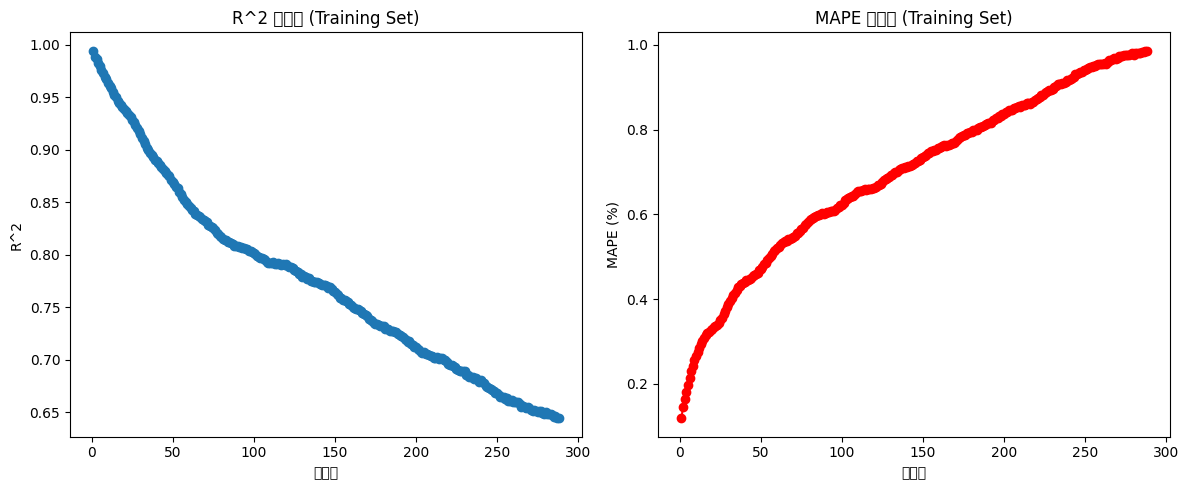

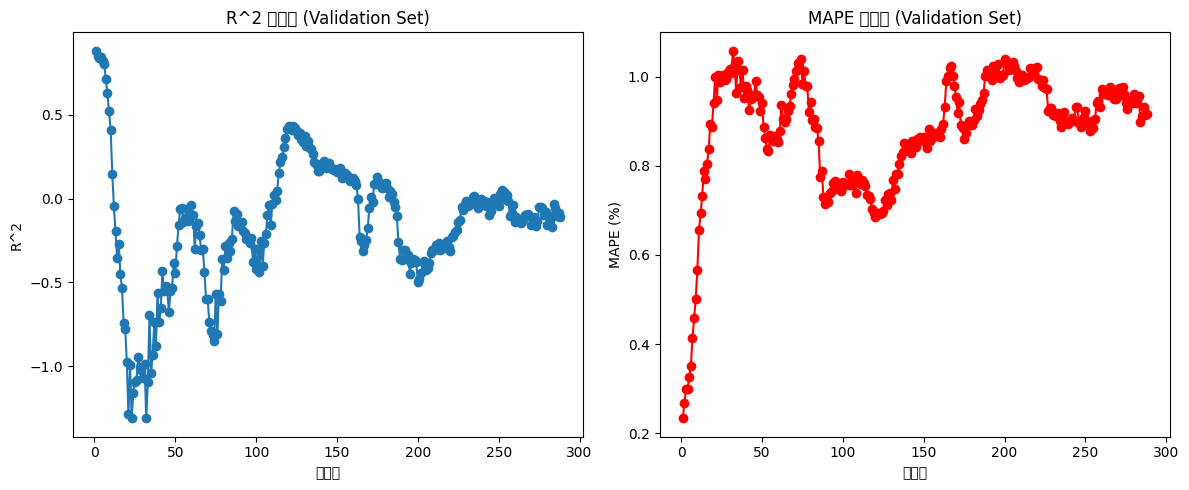

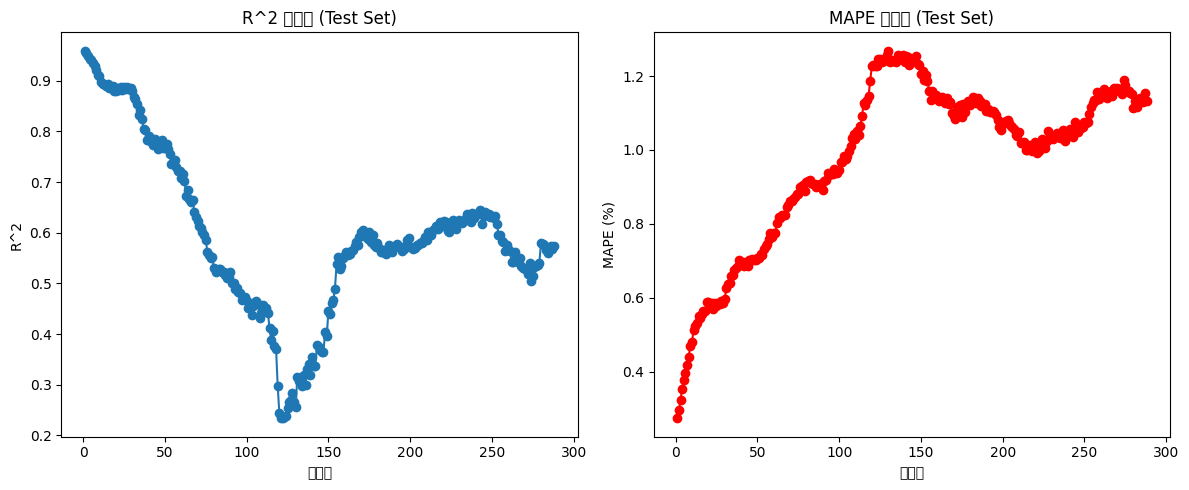

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import load
from sklearn.metrics import r2_score, mean_absolute_error

# 定義計算平均絕對百分比誤差 (MAPE) 的函數
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def evaluate_model(data_set, model, scalers, target_col, time_steps, dataset_name):
    # 創建數據集
    X, y = create_dataset(data_set.drop(columns=[f'{target_col}_target_{i}' for i in range(1, 289)]),
                          data_set[f"{target_col}_target_1"], time_steps)
    
    # 檢查數據集是否為空
    if len(X) == 0:
        print(f"{dataset_name} is empty for {target_col}")
        return -1, -1  # 返回兩個無效的指標值
    
    # 數據整形
    X = X.reshape((X.shape[0], -1))
    
    # 使用模型進行預測
    y_pred = model.predict(X)
    
    # 將預測值和真實值恢復到原始尺度
    y_pred_rescaled = scalers["scaler_" + target_col].inverse_transform(y_pred.reshape(-1, 1)).flatten()
    y_rescaled = scalers["scaler_" + target_col].inverse_transform(y.reshape(-1, 1)).flatten()

    # 計算性能指標
    r2 = r2_score(y_rescaled, y_pred_rescaled)
    mape = mean_absolute_percentage_error(y_rescaled, y_pred_rescaled)
    
    return r2, mape

# 評估模型
r2_results = {
    "Training Set": [],
    "Validation Set": [],
    "Test Set": []
}
mape_results = {
    "Training Set": [],
    "Validation Set": [],
    "Test Set": []
}

datasets = {
    "Training Set": train_data,
    "Validation Set": val_data,
    "Test Set": test_data
}

for t in range(1, 289):  # 從t1到t288
    for dataset_name, dataset in datasets.items():
        current_r2 = []
        current_mape = []
        
        for target_col in target_columns:
            # 加載模型
            model = load(f"water_model4/model_{target_col}_t{t}.joblib")

            # 評估模型
            r2, mape = evaluate_model(dataset, model, scalers, target_col, time_steps, dataset_name)
            current_r2.append(r2)
            current_mape.append(mape)
        
        r2_results[dataset_name].append(np.mean(current_r2))
        mape_results[dataset_name].append(np.mean(current_mape))

# 繪製R^2和MAPE的趨勢圖
for dataset_name in datasets.keys():
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(range(1, 289), r2_results[dataset_name], '-o')
    plt.title(f"R^2 趨勢圖 ({dataset_name})")
    plt.xlabel("時間步")
    plt.ylabel("R^2")

    plt.subplot(1, 2, 2)
    plt.plot(range(1, 289), mape_results[dataset_name], '-o', color='red')
    plt.title(f"MAPE 趨勢圖 ({dataset_name})")
    plt.xlabel("時間步")
    plt.ylabel("MAPE (%)")
    
    plt.tight_layout()
    plt.show()


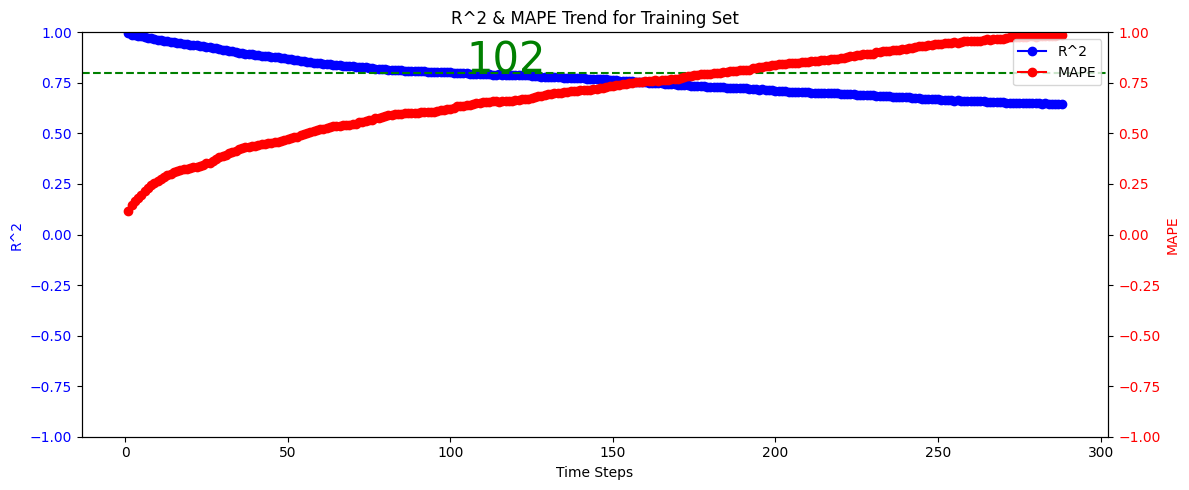

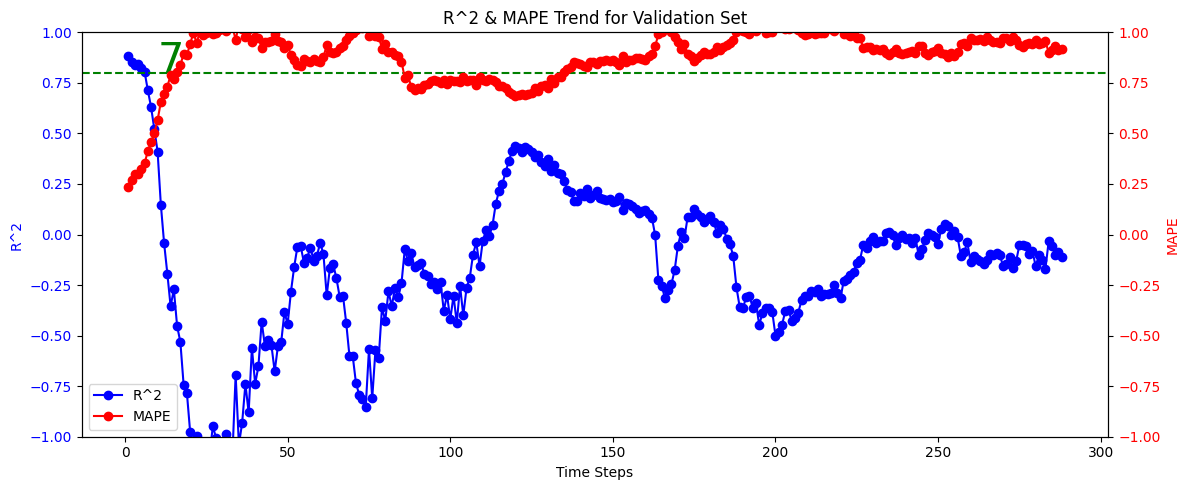

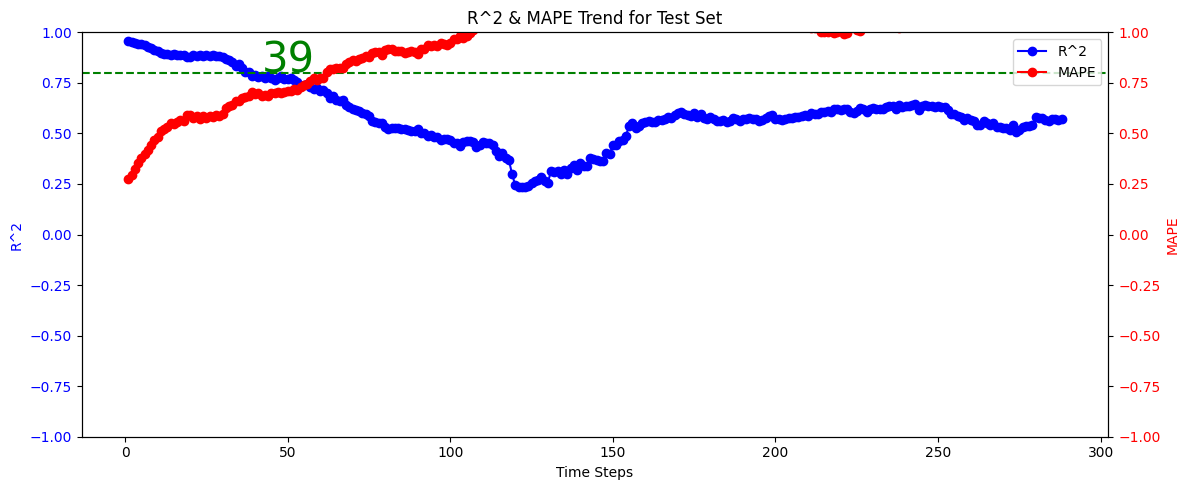

In [26]:
import matplotlib.pyplot as plt

# Plotting the R^2 and MAPE trends
for dataset_name in datasets.keys():
    fig, ax1 = plt.subplots(figsize=(12, 5))
    
    # Plotting R^2 on the left y-axis
    ax1.set_xlabel('Time Steps')
    ax1.set_ylabel('R^2', color='blue')
    ax1.plot(range(1, 289), r2_results[dataset_name], '-o', color='blue', label="R^2")
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_title(f"R^2 & MAPE Trend for {dataset_name}")
    ax1.set_ylim(-1, 1)  # Set R^2 scale to [-1, 1]

    # Drawing a line at R^2=0.8
    ax1.axhline(y=0.8, color='green', linestyle='--')
    
    # Finding the time step where R^2 goes below 0.8 for the first time
    try:
        x_pos = next(i for i, r2 in enumerate(r2_results[dataset_name]) if r2 < 0.8) + 1
        # Drawing a vertical line at the position where R^2 first goes below 0.8
        ax1.axvline(x=x_pos, color='green', linestyle='')

        # Offset for adjusting text position
        x_offset = 3  # This can be adjusted as needed
        y_offset = 0.001  # This can be adjusted as needed

        ax1.text(x_pos + x_offset, 0.8 - y_offset, str(x_pos), color='green', fontsize=30)
    except StopIteration:
        pass
    
    # Creating a second y-axis that shares the same x-axis with ax1
    ax2 = ax1.twinx()
    ax2.set_ylabel('MAPE', color='red')  # Removed the (%) for clarity, given new scale
    ax2.plot(range(1, 289), mape_results[dataset_name], '-o', color='red', label="MAPE")
    ax2.tick_params(axis='y', labelcolor='red')
    ax2.set_ylim(-1, 1)  # Set MAPE scale to [0, 1]

    # Display the legend
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc=0)
    
    fig.tight_layout()  # Ensure the plots don't overlap
    plt.show()


In [ ]:
from joblib import load


# 加載模型
loaded_model = load(r"C:\Users\rex\Desktop\git\data-processing\water_model4\model_1510H076 Water Level_t1.joblib")

# 查看特徵名稱
feature_names = loaded_model.booster_.feature_name()
print(feature_names)


In [ ]:
import os
import joblib
import numpy as np
import matplotlib.pyplot as plt

folder_path = r'C:\Users\rex\Desktop\git\data-processing\water_model4'

# 創建 'picture' 資料夾
picture_folder_path = os.path.join(folder_path, 'picture')
if not os.path.exists(picture_folder_path):
    os.makedirs(picture_folder_path)

all_files = os.listdir(folder_path)

for file in all_files:
    # 確認檔案是否是 .joblib 格式
    if file.endswith('.joblib'):
        
        # 讀取模型
        model_path = os.path.join(folder_path, file)
        model = joblib.load(model_path)
        
        # 從模型中提取特徵名稱
        features = model.feature_name_
        
        # 獲取特徵的重要性
        feature_importances = model.feature_importances_
        
        # 確認特徵的數量
        print(f"Number of features in model {file}: {len(feature_importances)}")
        print(f"Number of features in features list: {len(features)}")

        # 如果數量不一致，則跳過此模型
        if len(features) != len(feature_importances):
            print(f"Feature mismatch for model {file}. Skipping...")
            continue

        # 將特徵重要性排序
        sorted_idx = np.argsort(feature_importances)[::-1]
        top_features = np.array(features)[sorted_idx]
        top_importances = feature_importances[sorted_idx]

        # 繪製特徵重要性
        plt.figure(figsize=(20, 12))
        plt.title(f"Feature importances for {file}")
        plt.bar(top_features[:20], top_importances[:20])
        plt.xticks(rotation=45)
        
        # 儲存圖片到 'picture' 資料夾中
        picture_name = f"{file}_feature_importance.png"
        picture_path = os.path.join(picture_folder_path, picture_name)
        plt.savefig(picture_path)
        
        # 關閉當前圖片，以釋放記憶體
        plt.close()


In [ ]:
from joblib import load

# 加载模型
model_path = r"C:\Users\rex\Desktop\git\data-processing\076_model288\model_1510H076 Water Level_t1.joblib"
loaded_model = load(model_path)

# 获取特征的重要性
feature_importances = loaded_model.feature_importances_

# 将特征的重要性与其对应的名称组合在一起
features = list(zip(loaded_model.booster_.feature_name(), feature_importances))

# 根据重要性进行排序
sorted_features = sorted(features, key=lambda x: x[1], reverse=True)

# 选择前20个最重要的特征
top_20_features = sorted_features[:20]

for feature, importance in top_20_features:
    print(f"{feature}: {importance}")



In [ ]:
# 假設您的原始數據集存儲在一個名為 data 的 DataFrame 中
feature_name = data.columns[259]
print(feature_name)


In [ ]:
# T+1~T+288 訓練並繪圖
import random
from joblib import dump
# 隨機種子
seed_value = 42             # 種子值
random.seed(seed_value)     # random 模組設定隨機數生成器的種子
np.random.seed(seed_value)  # NumPy 模組設定隨機數生成器的種子

# 定義時間步長
time_steps = 48

# 檢查 "water_model1" 資料夾存在
if not os.path.exists("water_model2"):
    os.makedirs("water_model2")
    
def rolling_window_cross_val(data, train_size_fraction, val_size_fraction, step_size, target_columns):
    total_size = len(data)
    train_size = int(total_size * train_size_fraction)
    val_size = int(total_size * val_size_fraction)
    
    start_idx = 0
    end_idx = train_size + val_size
    
    while end_idx <= total_size:
        train_temp = data.iloc[start_idx : start_idx + train_size]
        val_temp = data.iloc[start_idx + train_size : end_idx]
        
        # 在此處使用 train_temp 和 val_temp 進行模型訓練和驗證
        for target_col in target_columns:
            plt.figure(figsize=(20, 6))
            
            true_values = [] 
            predictions = [] 
            test_temp = val_temp.copy()
            
            for t in range(1, 289):
                timestamp = test_temp.index[-1]
                target = f'{target_col}_target_{t}'
                
                if t > 1:
                    test_temp.loc[timestamp, target_col] = predictions[-1]
                
                timestamp = test_temp.index[-1]
                target = f"{target_col}_target_{t}"

                X_train, y_train = create_dataset(train_temp.drop(columns=[f'{target_col}_target_{i}' for i in range(1, 289)]), train_temp[target], time_steps)
                X_val, y_val = create_dataset(val_temp.drop(columns=[f'{target_col}_target_{i}' for i in range(1, 289)]), train_temp[target], time_steps)
                X_test, y_test = create_dataset(test_temp.drop(columns=[f'{target_col}_target_{i}' for i in range(1, 289)]), train_temp[target], time_steps)
                
                X_train = X_train.reshape((X_train.shape[0], -1))
                X_val = X_val.reshape((X_val.shape[0], -1))
                X_test = X_test.reshape((X_test.shape[0], -1))
                    
                # 訓練模型並進行預測
                model = lgb.LGBMRegressor(
                    objective='regression',            # 目標函數，這裡是回歸問題
                    num_leaves=28,                     # 樹中葉子的最大數量
                    learning_rate=0.02,                # 學習率
                    n_estimators=700,                  # 弱學習器或者說決策樹的數量
                    max_bin=40,                        # 數據分箱的最大數量，控制數據劃分的總數量 LightGBM 將連續的特徵值轉換為離散的劃分來建立樹
                    subsample=0.7777777777777778,      # 構建每一棵決策樹時，採樣的數據比例
                    subsample_freq=3,                  # subsample_freq 控制了取樣的頻率(bagging的頻率)，0表示不使用bagging。k表示每k次迭代執行一次bagging
                    colsample_bytree=0.7777777777777778, # 構建每棵決策樹時，選取的特徵的比例
                    min_child_samples=5,               # 一個葉子中數據的最小數量
                    min_child_weight=11,               # 一個葉子中數據的最小權重
                    verbose=0,                         # 若為0，則不輸出訓練過程；>0表示輸出詳細資訊
                    device='cpu',                       # 使用GPU進行訓練，'cpu'表示使用CPU
                    random_state=seed_value,
                    force_col_wise=True
                )
                feature_names = train_data.columns.tolist()
                model.fit(X_train, y_train,eval_set=[(X_val, y_val)],eval_metric="mse", feature_name=feature_names)
                
                # 儲存模型
                dump(model, f"water_model2/model_{target_col}_t{t}.joblib")
                
                #評估模型
                y_pred = model.predict(X_test)
                y_pred_rescaled = scalers["scaler_" + target_col].inverse_transform(y_pred.reshape(-1, 1)).flatten()
                y_test_rescaled = scalers["scaler_" + target_col].inverse_transform(y_test.reshape(-1, 1)).flatten()
                
                true_values.append(y_test_rescaled[-1]) # 取最後一個真實值
                predictions.append(y_pred_rescaled[-1]) # 取最後一個預測值
                
                r2 = r2_score(y_test_rescaled, y_pred_rescaled)
                mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
                mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
                rmse = np.sqrt(mse)
                mape = mean_absolute_percentage_error(y_test_rescaled, y_pred_rescaled)
                # timestamp 為測試數據集中的預測開始的時間點
                print(f"Timestamp: {timestamp}, Target: {target}, r2: {r2}, mse: {mse}, mae: {mae}, rmse: {rmse}, mape: {mape}")
                
            #繪製真實值與預測值
            plt.plot(true_values, label="True Values", color="blue")
            plt.plot(predictions, label="Predictions", color="red", linestyle="--")
            plt.title(f"predictions vs True Values for {target_col}")
            plt.xlabel("Time")
            plt.ylabel("Water Level")
            plt.legend()
            plt.grid(True)
            plt.show()
        start_idx += step_size
        end_idx += step_size
        

# 設定參數
train_size_fraction = 0.8
val_size_fraction = 0.1
step_size = int(len(data) * 0.1)

# 執行交叉驗證
rolling_window_cross_val(data, train_size_fraction, val_size_fraction, step_size, target_columns)

In [ ]:
import random
from joblib import dump

#隨機種子
seed_value = 42             # 種子值
random.seed(seed_value)     # random 模組設定隨機數生成器的種子
np.random.seed(seed_value)  # NumPy 模組設定隨機數生成器的種子

# 切分數據集，前80%的數據作為訓練集，剩下的20%作為測試集。
train_size = int((len(data) *0.8))
train_data = data[:train_size]
test_data = data[train_size:]

#然後將訓練集中最後的10%作為驗證集。
val_size = int(len(train_data) *0.1)
train_data, val_data = train_data[:-val_size], train_data[-val_size:]

#定義時間步長
time_steps = 48

#副本的創建
train_temp = train_data.copy()
val_temp = val_data.copy()
test_temp = test_data.copy()


def model_exists(target_col, t):
    return os.path.exists(f"water_model2/model_{target_col}_t{t}.joblib")


for target_col in target_columns:
    plt.figure(figsize=(20, 6))
    
    true_values = []  # 儲存真實值
    predictions = []  # 儲存預測值
    test_temp = test_data.copy()
    
    for t in range(1, 289):
        # 如果模型已經存在，則跳過當前迭代
        if model_exists(target_col, t):
            continue
        
        # 如果t不等於1，更新test_temp中的特定列值為上一個時刻的預測值
        if t > 1 and predictions: 
            # 將 T+1 的預測值設置為 T+2 的輸入
            test_temp.loc[timestamp, target_col] = predictions[-1]
        # 獲取測試集該時刻的時間戳記
        timestamp = test_temp.index[-1]
        
        target = f"{target_col}_target_{t}"
        
            
        # 切分訓練集、驗證集與測試集
        X_train, y_train = create_dataset(train_temp.drop(columns=[target]), train_temp[target], time_steps)
        X_val, y_val = create_dataset(val_temp.drop(columns=[target]), val_temp[target], time_steps)
        X_test, y_test = create_dataset(test_temp.drop(columns=[target]), test_temp[target], time_steps)
        
        # 重塑 X_train, X_val 和 X_test
        X_train = X_train.reshape((X_train.shape[0], -1))
        X_val = X_val.reshape((X_val.shape[0], -1))
        X_test = X_test.reshape((X_test.shape[0], -1))
        
        # 訓練模型並進行預測
        model = lgb.LGBMRegressor(
            objective='regression',            # 目標函數，這裡是回歸問題
            num_leaves=28,                     # 樹中葉子的最大數量
            learning_rate=0.02,                # 學習率
            n_estimators=700,                  # 弱學習器或者說決策樹的數量
            max_bin=40,                        # 數據分箱的最大數量，控制數據劃分的總數量 LightGBM 將連續的特徵值轉換為離散的劃分來建立樹
            subsample=0.7777777777777778,      # 構建每一棵決策樹時，採樣的數據比例
            subsample_freq=3,                  # subsample_freq 控制了取樣的頻率(bagging的頻率)，0表示不使用bagging。k表示每k次迭代執行一次bagging
            colsample_bytree=0.7777777777777778, # 構建每棵決策樹時，選取的特徵的比例
            min_child_samples=5,               # 一個葉子中數據的最小數量
            min_child_weight=11,               # 一個葉子中數據的最小權重
            verbose=0,                         # 若為0，則不輸出訓練過程；>0表示輸出詳細資訊
            device='gpu',                       # 使用GPU進行訓練，'cpu'表示使用CPU
            random_state=seed_value
        )
        
        model.fit(X_train, y_train,eval_set=[(X_val, y_val)],eval_metric="mse")
        
        # 儲存模型
        dump(model, f"water_model2/model_{target_col}_t{t}.joblib")
        
        #評估模型
        y_pred = model.predict(X_test)
        y_pred_rescaled = scalers["scaler_" + target_col].inverse_transform(y_pred.reshape(-1, 1)).flatten()
        y_test_rescaled = scalers["scaler_" + target_col].inverse_transform(y_test.reshape(-1, 1)).flatten()
        
        true_values.append(y_test_rescaled[-1]) # 取最後一個真實值
        predictions.append(y_pred_rescaled[-1]) # 取最後一個預測值
        
        r2 = r2_score(y_test_rescaled, y_pred_rescaled)
        mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
        mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
        rmse = np.sqrt(mse)
        mape = mean_absolute_percentage_error(y_test_rescaled, y_pred_rescaled)
        # timestamp 為測試數據集中的預測開始的時間點
        print(f"Timestamp: {timestamp}, Target: {target}, r2: {r2}, mse: {mse}, mae: {mae}, rmse: {rmse}, mape: {mape}")
        
    #繪製真實值與預測值
    plt.plot(true_values, label="True Values", color="blue")
    plt.plot(predictions, label="Predictions", color="red", linestyle="--")
    plt.title(f"predictions vs True Values for {target_col}")
    plt.xlabel("Time")
    plt.ylabel("Water Level")                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
    plt.legend()
    plt.grid(True)
    plt.show()
    

In [ ]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=1000, n_features=50, random_state=42)


In [ ]:
import lightgbm as lgb

train_data = lgb.Dataset(X, label=y)

params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'binary_logloss',
    'device': 'gpu'  
}

num_round = 100
bst = lgb.train(params, train_data, num_round)


In [ ]:
import random
from joblib import dump
#隨機種子
seed_value = 42             # 種子值
random.seed(seed_value)     # random 模組設定隨機數生成器的種子
np.random.seed(seed_value)  # NumPy 模組設定隨機數生成器的種子

# 切分數據集，前80%的數據作為訓練集，剩下的20%作為測試集。
train_size = int((len(data) *0.8))
train_data = data[:train_size]
test_data = data[train_size:]

#然後將訓練集中最後的10%作為驗證集。
val_size = int(len(train_data) *0.1)
train_data, val_data = train_data[:-val_size], train_data[-val_size:]

#定義時間步長
time_steps = 48

#副本的創建
train_temp = train_data.copy()
val_temp = val_data.copy()
test_temp = test_data.copy()


Size of data_temp_loop: 72
Timestamp: 2020-05-29 23:00:00, Target: 1510H071 Water Level_target_1, r2: 0.702637361056565, mse: 0.001899816859916371, mae: 0.037736895256889134, rmse: 0.04358688862394712, mape: 0.176860522657792
1510H071 Water Level predictions saved to 1510H071 Water Level_predictions.xlsx
Timestamp: 2020-05-29 23:00:00, Target: 1510H071 Water Level_target_2, r2: 0.7188119814584253, mse: 0.002792353239683671, mae: 0.0439334191363138, rmse: 0.052842721728575556, mape: 0.20621668375235724
1510H071 Water Level predictions saved to 1510H071 Water Level_predictions.xlsx
Timestamp: 2020-05-29 23:00:00, Target: 1510H071 Water Level_target_3, r2: 0.7190917677252042, mse: 0.0029212505404965523, mae: 0.04339880402582219, rmse: 0.054048594250882716, mape: 0.20378038758580105
1510H071 Water Level predictions saved to 1510H071 Water Level_predictions.xlsx
Timestamp: 2020-05-29 23:00:00, Target: 1510H071 Water Level_target_4, r2: 0.7424138033683927, mse: 0.002790517130175725, mae: 0.0

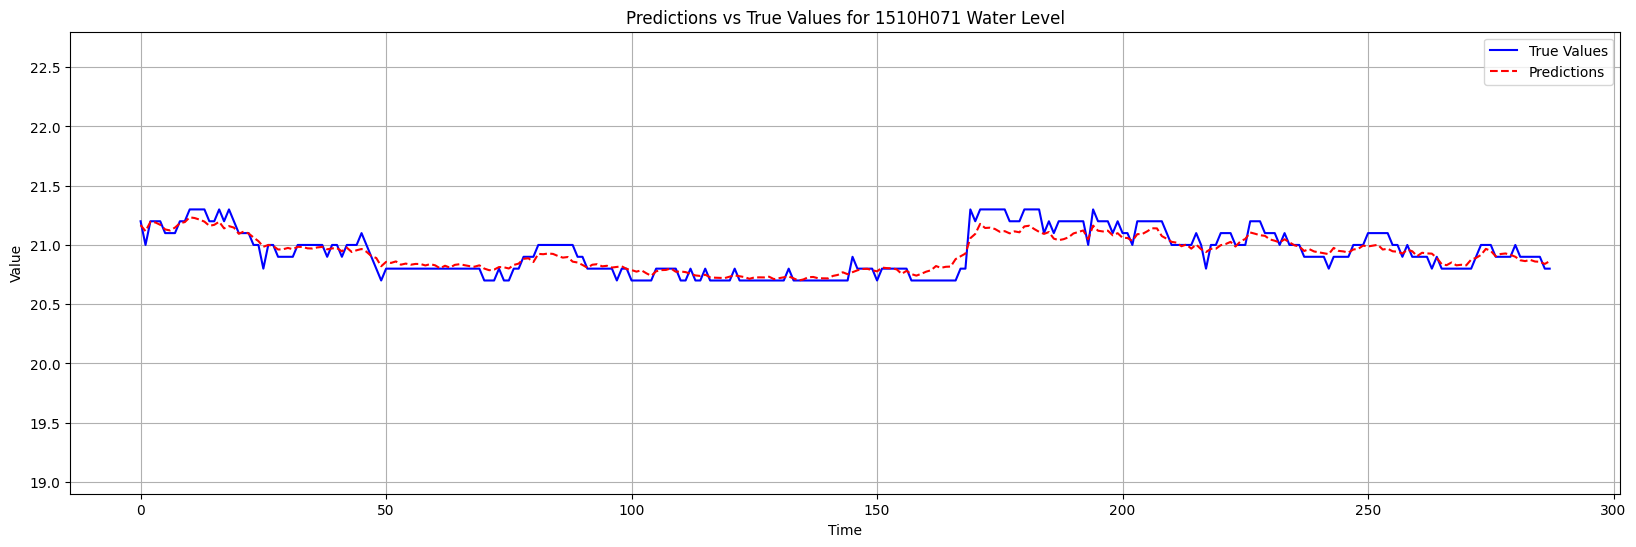

In [21]:
import datetime
import numpy as np
from joblib import load
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


specified_timestamp = "2020-05-29 23:00:00"
specified_timestamp_dt = datetime.datetime.strptime(specified_timestamp, '%Y-%m-%d %H:%M:%S')

data_temp = data.loc[specified_timestamp_dt - datetime.timedelta(hours=24): 
                     specified_timestamp_dt + datetime.timedelta(hours=47)]

global_ymin = data[target_columns].min().min()
global_ymax = data[target_columns].max().max()


for target_col in target_columns:
    data_temp_loop = data_temp.copy()  # 這裡創建了data_temp的一個副本，使其在每次迴圈中保持原始狀態

    print(f"Size of data_temp_loop: {len(data_temp_loop)}")

    # 在進行預測之前，將這些數據值轉換回原始尺度
    global_ymin_rescaled = scalers["scaler_" + target_col].inverse_transform([[global_ymin]])[0][0]
    global_ymax_rescaled = scalers["scaler_" + target_col].inverse_transform([[global_ymax]])[0][0]
    
    true_values = []
    predictions = []    

    for t in range(1, 289):

        # 載入模型
        model = load(f"water_model4/model_{target_col}_t{t}.joblib")

        # 如果t不等於1，更新test_temp中的特定列值為上一個時刻的預測值
        if t > 1 and predictions:
            # 將 T+1 的預測值設置為 T+2 的輸入
            data_temp_loop.loc[specified_timestamp_dt, target_col] = predictions[-1]
        
        target = f"{target_col}_target_{t}"

        # 切分測試集
        X_test, y_test = create_dataset(data_temp_loop.drop(columns=[f'{target_col}_target_{i}' for i in range(1, 289)]), data_temp_loop[target], time_steps)
        if len(X_test) == 0:
            print(f"Timestamp: {specified_timestamp}, Target: {target}, X_test is empty!")
            continue  # 如果X_test為空，則跳過後續的代碼並進行下一次迴圈        
        # 重塑 X_test
        X_test = X_test.reshape((X_test.shape[0], -1))
        
        # 進行預測
        y_pred = model.predict(X_test)
        y_pred_rescaled = scalers["scaler_" + target_col].inverse_transform(y_pred.reshape(-1, 1)).flatten()
        y_test_rescaled = scalers["scaler_" + target_col].inverse_transform(y_test.reshape(-1, 1)).flatten()
        
        true_values.append(y_test_rescaled[-1])  # 取最後一個真實值
        predictions.append(y_pred_rescaled[-1])  # 取最後一個預測值
        
        r2 = r2_score(y_test_rescaled, y_pred_rescaled)
        mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
        mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
        rmse = np.sqrt(mse)
        mape = mean_absolute_percentage_error(y_test_rescaled, y_pred_rescaled)
        
        # timestamp 為測試數據集中的預測開始的時間點
        print(f"Timestamp: {specified_timestamp}, Target: {target}, r2: {r2}, mse: {mse}, mae: {mae}, rmse: {rmse}, mape: {mape}")
        
        df = pd.DataFrame({
            "True Values": true_values,
            "Predictions": predictions
        })
        
        output_filename = f"{target_col}_predictions.xlsx"
        with pd.ExcelWriter(output_filename, engine="openpyxl") as writer:
            df.to_excel(writer, sheet_name=target_col, index=False)
        print(f"{target_col} predictions saved to {output_filename}")
        
    # 繪製真實值與預測值
    plt.figure(figsize=(20, 6))
    plt.plot(true_values, label="True Values", color="blue")
    plt.plot(predictions, label="Predictions", color="red", linestyle="--")
    
    # 使用轉換回原始尺度的最大和最小值設置y軸尺度
    plt.ylim(global_ymin_rescaled, global_ymax_rescaled)
    
    plt.title(f"Predictions vs True Values for {target_col}")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    plt.legend()
    plt.show()

In [ ]:
#前20重要特徵

import os
import joblib
import numpy as np
import matplotlib.pyplot as plt

folder_path = r'C:\Users\rex\Desktop\git\data-processing\water_model2'

# 創建 'picture' 資料夾
picture_folder_path = os.path.join(folder_path, 'picture')
if not os.path.exists(picture_folder_path):
    os.makedirs(picture_folder_path)

all_files = os.listdir(folder_path)

for file in all_files:
    # 確認檔案是否是 .joblib 格式
    if file.endswith('.joblib'):
        
        # 讀取模型
        model_path = os.path.join(folder_path, file)
        model = joblib.load(model_path)
        
        # 從模型中提取特徵名稱
        features = model.feature_name_
        
        # 獲取特徵的重要性
        feature_importances = model.feature_importances_
        
        # 確認特徵的數量
        print(f"Number of features in model {file}: {len(feature_importances)}")
        print(f"Number of features in features list: {len(features)}")

        # 如果數量不一致，則跳過此模型
        if len(features) != len(feature_importances):
            print(f"Feature mismatch for model {file}. Skipping...")
            continue

        # 將特徵重要性排序
        sorted_idx = np.argsort(feature_importances)[::-1]
        top_features = np.array(features)[sorted_idx]
        top_importances = feature_importances[sorted_idx]

        # 繪製特徵重要性
        plt.figure(figsize=(20, 12))
        plt.title(f"Feature importances for {file}")
        plt.bar(top_features[:20], top_importances[:20])
        plt.xticks(rotation=45)
        
        # 儲存圖片到 'picture' 資料夾中
        picture_name = f"{file}_feature_importance.png"
        picture_path = os.path.join(picture_folder_path, picture_name)
        plt.savefig(picture_path)
        
        # 關閉當前圖片，以釋放記憶體
        plt.close()


In [ ]:
#light 參數隨機選擇一定數量的組合。

# 列出目標水位列
target_columns = [
    "1510H084 Water Level",
    "1510H076 Water Level",
    "1510H071 Water Level",
    "1510H057 Water Level"
]

# 1. 增加目標列：T+1到T+48的目標水位
for target_col in target_columns:
    for t in range(1, 49):
        target = f'{target_col}_target_{t}'
        data[target] = data[target_col].shift(-t)

# 移除含有 NaN 的行
data = data.dropna()

# 3. 切分數據集
train_size = int(len(data) * 0.8)
train_data = data[:train_size]
test_data = data[train_size:]

# 進一步切分訓練集和驗證集
val_size = int(len(train_data) * 0.1)
train_data, val_data = train_data[:-val_size], train_data[-val_size:]

# 定義時間步長
time_steps = 48

import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

# 定義待調參數
param_distributions = {
    'num_leaves': [24, 28, 32, 36],
    'learning_rate': [0.01, 0.02, 0.05, 0.1],
    'n_estimators': [500, 700, 900, 1100],
    'max_bin': [30, 40, 50],
    'subsample': [0.7, 0.8, 0.9],
    'subsample_freq': [2, 3, 4],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'min_child_samples': [4, 5, 6, 7],
    'min_child_weight': [10, 11, 12]
}

estimator = lgb.LGBMRegressor(objective='regression', verbose=0, device='gpu')

# 使用第一個目標列來生成X_train和y_train
target = f'{target_columns[0]}_target_48'
X_train, y_train = create_dataset(train_data.drop(columns=[target]), train_data[target], time_steps)

# 使用 RandomizedSearchCV 進行參數搜尋
random_search = RandomizedSearchCV(estimator, param_distributions,
                                   n_iter=100,     # 要試驗的不同參數組合數量
                                   cv=3,           # 3折交叉驗證
                                   scoring='neg_mean_squared_error',
                                   verbose=1,
                                   n_jobs=-1,      # 使用所有可用的CPU核心進行計算
                                   random_state=42)  # 設置隨機種子

# 使用您的訓練數據
X, y = X_train, y_train
random_search.fit(X, y)

print('Best parameters found by random search are:', random_search.best_params_)
print('Best score found by random search is:', random_search.best_score_)

In [ ]:
# 繪製雨量直方圖與真實預測水位趨勢圖
import datetime
import numpy as np
from joblib import load
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


specified_timestamp = "2020-05-29 23:00:00"
specified_timestamp_dt = datetime.datetime.strptime(specified_timestamp, '%Y-%m-%d %H:%M:%S')

data_temp = data.loc[specified_timestamp_dt - datetime.timedelta(hours=24): 
                     specified_timestamp_dt + datetime.timedelta(hours=47)]

global_ymin = data[target_columns].min().min()
global_ymax = data[target_columns].max().max()


for target_col in target_columns:
    data_temp_loop = data_temp.copy()  # 這裡創建了data_temp的一個副本，使其在每次迴圈中保持原始狀態

    print(f"Size of data_temp_loop: {len(data_temp_loop)}")

    # 在進行預測之前，將這些數據值轉換回原始尺度
    global_ymin_rescaled = scalers["scaler_" + target_col].inverse_transform([[global_ymin]])[0][0]
    global_ymax_rescaled = scalers["scaler_" + target_col].inverse_transform([[global_ymax]])[0][0]
    
    true_values = []
    predictions = []    
    
    for t in range(1, 289):

        # 載入模型
        model = load(f"water_model3/model_{target_col}_t{t}.joblib")

        # 如果t不等於1，更新test_temp中的特定列值為上一個時刻的預測值
        if t > 1 and predictions:
            # 將 T+1 的預測值設置為 T+2 的輸入
            data_temp_loop.loc[specified_timestamp_dt, target_col] = predictions[-1]
        
        target = f"{target_col}_target_{t}"

        # 切分測試集
        X_test, y_test = create_dataset(data_temp_loop.drop(columns=[f'{target_col}_target_{i}' for i in range(1, 289)]), data_temp_loop[target], time_steps)
        if len(X_test) == 0:
            print(f"Timestamp: {specified_timestamp}, Target: {target}, X_test is empty!")
            continue  # 如果X_test為空，則跳過後續的代碼並進行下一次迴圈        
        # 重塑 X_test
        X_test = X_test.reshape((X_test.shape[0], -1))
        
        # 進行預測
        y_pred = model.predict(X_test)
        y_pred_rescaled = scalers["scaler_" + target_col].inverse_transform(y_pred.reshape(-1, 1)).flatten()
        y_test_rescaled = scalers["scaler_" + target_col].inverse_transform(y_test.reshape(-1, 1)).flatten()
        
        true_values.append(y_test_rescaled[-1])  # 取最後一個真實值
        predictions.append(y_pred_rescaled[-1])  # 取最後一個預測值
        
        r2 = r2_score(y_test_rescaled, y_pred_rescaled)
        mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
        mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
        rmse = np.sqrt(mse)
        mape = mean_absolute_percentage_error(y_test_rescaled, y_pred_rescaled)
        
        # timestamp 為測試數據集中的預測開始的時間點
        print(f"Timestamp: {specified_timestamp}, Target: {target}, r2: {r2}, mse: {mse}, mae: {mae}, rmse: {rmse}, mape: {mape}")
        
    # 繪製真實值與預測值
    plt.figure(figsize=(20, 6))
    plt.plot(true_values, label="True Values", color="blue")
    plt.plot(predictions, label="Predictions", color="red", linestyle="--")
    
    # 添加次坐標軸繪製雨量
    ax1 = plt.gca()  # 獲取當前坐標軸
    ax2 = ax1.twinx()  # 獲取次坐標軸
    rainfalls = data_temp_loop["19335 Rainfall"].values  # 你要使用的雨量資料
    ax2.bar(data_temp_loop.index, -rainfalls, color='green', alpha=0.3, label='Rainfall')  # 倒立的直方圖
    ax2.set_ylabel('Rainfall', color='green')
    ax2.tick_params(axis='y', labelcolor='green')
    
    # 使用轉換回原始尺度的最大和最小值設置y軸尺度
    plt.ylim(global_ymin_rescaled, global_ymax_rescaled)
    
    plt.title(f"Predictions vs True Values for {target_col}")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    plt.legend()
    plt.show()

In [ ]:
import datetime

specified_timestamp = "2022-12-25 23:00:00" 
specified_timestamp_dt = datetime.datetime.strptime(specified_timestamp, '%Y-%m-%d %H:%M:%S')
time_steps = 48
# 根據指定的時間找到相對應的數據
specified_data = data[data.index == specified_timestamp_dt]

for target_col in target_columns:
    plt.figure(figsize=(20, 6))
    
    true_values = []  # 存儲真實值
    predictions = []  # 存儲預測值
    
    for t in range(1, 49):
        target = f'{target_col}_target_{t}'
        
        if target in specified_data.columns:  # 確保測試集有這個目標列
            # 切分測試集
            X_test, y_test = create_dataset(specified_data.drop(columns=[target]), specified_data[target], time_steps)
            X_test = X_test.reshape((X_test.shape[0], -1))
            
            # 讀取模型進行預測
            model_path = f'water_model1/model_{target_col}_t{t}.joblib'
            model = load(model_path)
            
            y_pred = model.predict(X_test)
            y_pred_rescaled = scalers['scaler_' + target_col].inverse_transform(y_pred.reshape(-1, 1)).flatten()
            y_test_rescaled = scalers['scaler_' + target_col].inverse_transform(y_test.reshape(-1, 1)).flatten()

            true_values.append(y_test_rescaled[0])  # 添加真實值
            predictions.append(y_pred_rescaled[0])  # 添加預測值

            r2 = r2_score(y_test_rescaled, y_pred_rescaled)
            mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
            mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
            rmse = np.sqrt(mse)
            mape = mean_absolute_percentage_error(y_test_rescaled, y_pred_rescaled)  
            
            print(f"Timestamp: {specified_timestamp_dt}, Target: {target}, r2: {r2}, mse: {mse}, mae: {mae}, rmse: {rmse}")

    # 繪製真實值和預測值
    plt.plot(true_values, label="True Values", color="blue")
    plt.plot(predictions, label="Predictions", color="red", linestyle="--")
    plt.title(f"Predictions vs True Values for {target_col}")
    plt.xlabel("Time")
    plt.ylabel("Water Level")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
#繪圖預測值與真實值單一時間
# import matplotlib.pyplot as plt
# from keras.models import load_model
# from sklearn.metrics import mean_squared_error, r2_score

# # 定義時間步長
# time_steps = 48

# # 對於每一個目標，進行一次以上的過程
# for target_col in target_columns:
#     for t in range(1, 49):
#         target = f'{target_col}_target_{t}'

#         # 切分測試集
#         X_test, y_test = create_dataset(test_data, test_data[target], time_steps)

#         # 載入模型
#         model = load_model(f'models/model-{target_col}-{t}.h5')

#         # 進行預測
#         y_pred = model.predict(X_test)

#         # 將預測值的縮放逆轉回來
#         y_pred_rescaled = scalers['scaler_' + target].inverse_transform(y_pred)

#         # 將真實值的縮放逆轉回來
#         y_test_rescaled = scalers['scaler_' + target].inverse_transform(y_test.reshape(-1, 1))

#         # 計算R^2和RMSE
#         r2 = r2_score(y_test_rescaled, y_pred_rescaled)
#         rmse = mean_squared_error(y_test_rescaled, y_pred_rescaled, squared=False)
#         print(f'Target: {target}, R^2: {r2}, RMSE: {rmse}')

#         # 繪製圖形
#         plt.figure(figsize=(14, 6))
#         plt.plot(y_test_rescaled, label='True')
#         plt.plot(y_pred_rescaled, label='Predicted')
#         plt.title(target)
#         plt.xlabel('Time')
#         plt.ylabel('Water Level')
#         plt.legend()
#         plt.grid(True)
#         plt.show()


In [ ]:
# from joblib import load

# # 定義時間步長
# time_steps = 48

# # 對於每一個目標站點
# for target_col in target_columns:
#     plt.figure(figsize=(14, 6))
    
#     # 使用原始的test_data來擷取真實的水位數據
#     true_values = test_data[target_col].values[time_steps:time_steps+48]
#     plt.plot(true_values, label='True', color='blue')
    
#     predictions = []
#     # 對於每個T+1到T+48的預測
#     for t in range(1, 49):
#         target = f'{target_col}_target_{t}'

#         # 切分測試集
#         X_test, y_test = create_dataset(test_data.drop(columns=[target]), test_data[target], time_steps)
#         X_test = X_test.reshape((X_test.shape[0], -1))

#         # 載入模型
#         model = load(f'water_model/model_{target_col}_t{t}.joblib')

#         # 進行預測
#         y_pred = model.predict(X_test.reshape(X_test.shape[0], -1))

#         # 將預測值的縮放逆轉回來
#         y_pred_rescaled = scalers['scaler_' + target_col].inverse_transform(y_pred.reshape(-1, 1))

#         predictions.append(y_pred_rescaled[-1][0])  # 只取最後一個預測結果，即T+t的預測

#     # 在圖上繪製預測結果
#     plt.plot(predictions, label='Predicted', color='red', linestyle='--')
#     plt.title(target_col)
#     plt.xlabel('Time')
#     plt.ylabel('Water Level')
#     plt.legend()
#     plt.grid(True)
#     plt.show()


In [ ]:
# # TimeSeriesSplit交叉驗證
# n_splits = 5

# # RMSE
# def rmsle_cv(model, X, y):
#     tss = TimeSeriesSplit(n_splits=n_splits)
#     rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=tss))
#     return rmse

# # MAE
# def mae_cv(model, X, y):
#     tss = TimeSeriesSplit(n_splits=n_splits)
#     mae = -cross_val_score(model, X, y, scoring="neg_mean_absolute_error", cv=tss)
#     return mae

# # R-squared
# def r2_cv(model, X, y):
#     tss = TimeSeriesSplit(n_splits=n_splits)
#     r2 = cross_val_score(model, X, y, scoring="r2", cv=tss)
#     return r2


In [ ]:
# # 用來儲存模型的字典
# models_dict = {}

In [ ]:

# for target_name, target in zip(["1510H084 Water Level", "1510H076 Water Level", "1510H071 Water Level", "1510H057 Water Level"], [target_1510H084, target_1510H076, target_1510H071, target_1510H057]):
#     print("Target:", target_name)
#     common_index = data.index.intersection(target.index)
#     X = data.loc[common_index, features]  # 只選取兩個資料集共同的時間戳記和特徵
#     y_selected = target.loc[common_index]  # 只選取兩個資料集共同的時間戳記和目標變量

#     # 使用時間序列的方式拆分訓練集和驗證集
#     train_size = int(len(X) * 0.8)
#     X_train, X_valid = X.iloc[:train_size], X.iloc[train_size:]
#     y_train, y_valid = y_selected.iloc[:train_size], y_selected.iloc[train_size:]

    
#     # Lasso
#     lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0005, random_state=1))
#     lasso.fit(X_train, y_train)
    
#     # 在驗證集上進行預測並評估性能
#     y_pred = lasso.predict(X_valid)
    
#     # 更改評估函數，使之適用於驗證集
#     mae = mae_cv(lasso, X_train, y_train)
    
#     rmse = rmsle_cv(lasso, X_train, y_train)
    
#     r2 = r2_cv(lasso, X_train, y_train)

#     print("\nLasso MAE score: {:.4f} ({:.4f})\n".format(mae.mean(), mae.std()))
    
#     print("\nLasso RMSE score: {:.4f} ({:.4f})\n".format(rmse.mean(), rmse.std()))
    
#     print("\nLasso R^2 score: {:.4f} ({:.4f})\n".format(r2.mean(), r2.std()))
#     models_dict[target_name + '_lasso'] = lasso
    
    
#     #ENet
#     ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
#     ENet.fit(X_train, y_train)
#     mae = mae_cv(ENet, X_train, y_train)
#     rmse = rmsle_cv(ENet, X_train, y_train)
#     r2 = r2_cv(ENet, X_train, y_train)
#     print("\nElasticNet MAE score: {:.4f} ({:.4f})\n".format(mae.mean(), mae.std()))
#     print("\nElasticNet RMSE score: {:.4f} ({:.4f})\n".format(rmse.mean(), rmse.std()))
#     print("\nElasticNet R^2 score: {:.4f} ({:.4f})\n".format(r2.mean(), r2.std()))
#     models_dict[target_name + '_ENet'] = ENet
    
#     #KRR
#     KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree= 2,coef0=2.5)
#     KRR.fit(X_train, y_train)
#     mae = mae_cv(KRR, X_train, y_train)
#     rmse = rmsle_cv(KRR, X_train, y_train)
#     r2 = r2_cv(KRR, X_train, y_train)
#     print("\nKernel Ridge RMSE score: {:.4f} ({:.4f})\n".format(mae.mean(), mae.std()))
#     print("\nKernel Ridge RMSE score: {:.4f} ({:.4f})\n".format(rmse.mean(), rmse.std()))
#     print("\nKernel Ridge R^2 score: {:.4f} ({:.4f})\n".format(r2.mean(), r2.std()))
#     models_dict[target_name + '_KRR'] = KRR
    
#     #梯度提升
#     GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
#                                     max_depth=4, max_features='sqrt',
#                                     min_samples_leaf=15, min_samples_split=10,
#                                     loss='huber', random_state=5)
#     GBoost.fit(X_train, y_train)
#     mae = mae_cv(GBoost, X_train, y_train)
#     rmse = rmsle_cv(GBoost, X_train, y_train)
#     r2 = r2_cv(GBoost, X_train, y_train)
#     print("\nGradient Boosting MAE score: {:.4f} ({:.4f})\n".format(mae.mean(), mae.std()))
#     print("\nGradient Boosting RMSE score: {:.4f} ({:.4f})\n".format(rmse.mean(), rmse.std()))
#     print("\nGradient Boosting R^2 score: {:.4f} ({:.4f})\n".format(r2.mean(), r2.std()))
#     models_dict[target_name + '_GBoost'] = GBoost
    
#     #XGB
#     model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.4608,     # colsamples_bytree 是列的採樣率    # gamma 是節點劃分所需的最小損失減少值
#                              learning_rate=0.05, max_depth=3,               # learning_rate 是每次迭代的步長大小 # max_depth 是樹的最大深度
#                              min_child_weight=1.7817,n_estimators=2200,     # min_child_weight 是子節點所需最小樣本數   # n_estimators 是樹的數量
#                              subsample=0.5213,                              # subsample 是行的採樣率            
#                              reg_alpha=0.4640, reg_lambda=0.8571,           # reg_alpha 和 reg_lambda 是 L1 和 L2 正則化項的權重
#                              random_state=7, nthread=-1)                    # nthread 是 CPU 的使用數量
#     #XGBoost
#     model_xgb.fit(X_train, y_train)
#     mae = mae_cv(model_xgb, X_train, y_train)
#     rmse = rmsle_cv(model_xgb, X_train, y_train)
#     r2 = r2_cv(model_xgb, X_train, y_train)
#     print("\nXgboost MAE score: {:.4f} ({:.4f})\n".format(mae.mean(), mae.std()))
#     print("\nXgboost RMSE score: {:.4f} ({:.4f})\n".format(rmse.mean(), rmse.std()))
#     print("\nXgboost R^2 score: {:.4f} ({:.4f})\n".format(r2.mean(), r2.std()))
#     models_dict[target_name + '_xgb'] = model_xgb

#     #lgb
#     model_lgb = lgb.LGBMRegressor(objective='regression', num_leaves=28,
#                                 learning_rate=0.020000000000000004, n_estimators=700,
#                                 max_bin=40, subsample=0.7777777777777778, subsample_freq=3,
#                                 colsample_bytree= 0.7777777777777778,
#                                 min_child_samples=5, min_child_weight=11)

#     model_lgb.fit(X_train, y_train)
#     mae = mae_cv(model_lgb, X_train, y_train)
#     rmse = score = rmsle_cv(model_lgb, X_train, y_train)
#     r2 = r2_cv(model_lgb, X_train, y_train)
#     print("\nLGB MAE score: {:.4f} ({:.4f})\n".format(mae.mean(), mae.std()))
#     print("\nLGB RMSE score: {:.4f} ({:.4f})\n" .format(rmse.mean(), rmse.std()))
#     print("\nLGB R^2 score: {:.4f} ({:.4f})\n".format(r2.mean(), r2.std()))
#     models_dict[target_name + '_lgb'] = model_lgb

In [ ]:
# # 假設目標變量的名稱列表
# target_variables = ["1510H084 Water Level", "1510H076 Water Level", "1510H071 Water Level", "1510H057 Water Level"]

# # 設置window_size為48
# window_size = 48

# # 用來儲存所有目標的預測結果
# all_predictions = {}

# # 逐一對每個目標變量進行預測
# for target_variable in target_variables:
#     # 準備預測的輸入數據
#     input_data = data[features + [target_variable]].iloc[-window_size:]

#     # 使用之前訓練的標準化器對輸入數據進行標準化
#     for feature in features + [target_variable]:
#         input_data[feature] = scalers['scaler_' + feature].transform(input_data[feature].values.reshape(-1, 1))

#     # 使用訓練好的 Lasso 模型對未來的 48 個時間步進行預測
#     # 假設 Lasso 模型存儲在 'models_dict' 字典中
#     lasso_model = models_dict[target_variable + '_ENet']
#     predictions = lasso_model.predict(input_data[features])

#     # 將預測結果反標準化得到實際水位值
#     predictions = scalers['scaler_' + target_variable].inverse_transform(predictions.reshape(-1, 1))

#     # 儲存該目標的預測結果
#     all_predictions[target_variable] = predictions

# # all_predictions 包含了所有目標的預測結果，每個目標都有未來 48 個時間步的水位預測值（T+1 到 T+48）
# # 可以透過 all_predictions[target_variable] 獲得特定目標的預測結果
# print(all_predictions)

In [ ]:
# import matplotlib.pyplot as plt

# for target_name, target in zip(["1510H084 Water Level", "1510H076 Water Level", "1510H071 Water Level", "1510H057 Water Level"], [target_1510H084, target_1510H076, target_1510H071, target_1510H057]):
#     print("Target:", target_name)
#     common_index = data.index.intersection(target.index)
#     X = data.loc[common_index, features]
#     y_selected = target.loc[common_index]

#     # 使用時間序列的方式拆分訓練集和驗證集
#     train_size = int(len(X) * 0.8)
#     X_train, X_valid = X.iloc[:train_size], X.iloc[train_size:]
#     y_train, y_valid = y_selected.iloc[:train_size], y_selected.iloc[train_size:]

#     # Lasso (你可以在迴圈中添加其他模型)
#     lasso_model = models_dict[target_name + '_lasso']

#     # 使用預測數據繪圖
#     plt.figure(figsize=(10, 6))
    
#     # 1. 準備預測的輸入數據
#     target_variable = target_name
#     input_data = X_valid.iloc[-window_size:]

#     # 2. 使用之前訓練的標準化器對輸入數據進行標準化
#     for feature in features:
#         input_data[feature] = scalers['scaler_' + feature].transform(input_data[feature].values.reshape(-1, 1))

#     # 3. 使用訓練好的 Lasso 模型對未來的 48 個時間步進行預測
#     predictions = lasso_model.predict(input_data)

#     # 將預測結果反標準化得到實際水位值
#     predictions = scalers['scaler_' + target_variable].inverse_transform(predictions.reshape(-1, 1))

#     # 'predictions' 現在包含未來 48 個時間步的水位預測值（T+1 到 T+48）
#     forecast_index = pd.date_range(start=y_valid.index[-48], periods=window_size, freq=y_valid.index.inferred_freq)
#     plt.plot(forecast_index, predictions, label='Predict', color='red')
#     plt.plot(forecast_index, y_valid.values[-48:], label='True', color='blue')  # 只顯示未來 48 小時的真實值

#     plt.xlabel('Timestamp')
#     plt.ylabel(target_name)
#     plt.title('True and Predicted Values over Time Steps for Target: ' + target_name)
#     plt.legend()
#     plt.show()


In [ ]:
# target_variable = '1510H084 Water Level'
# input_data = data[features + [target_variable]].iloc[-window_size:]

# # 2. 使用之前訓練的標準化器對輸入數據進行標準化
# for feature in features + [target_variable]:
#     input_data[feature] = scalers['scaler_' + feature].transform(input_data[feature].values.reshape(-1, 1))

# # 3. 使用訓練好的 Lasso 模型對未來的 48 個時間步進行預測
# # 假設 Lasso 模型存儲在 'models_dict' 字典中
# lasso_model = models_dict[target_variable + '_lasso']
# predictions = lasso_model.predict(input_data[features])

# # 將預測結果反標準化得到實際水位值
# predictions = scalers['scaler_' + target_variable].inverse_transform(predictions.reshape(-1, 1))

# # 'predictions' 現在包含未來 48 個時間步的水位預測值（T+1 到 T+48）
# print(predictions)

In [ ]:
# !pip install statsmodels
# from statsmodels.graphics.tsaplots import plot_acf
# # Define the list of columns to analyze
# columns_to_analyze = ["1510H084 Water Level", "1510H076 Water Level", "1510H071 Water Level", "1510H057 Water Level", "19774 Rainfall", "20016 Rainfall", "19606 Rainfall", "19335 Rainfall"]

# # Create a figure and axes
# fig, axs = plt.subplots(len(columns_to_analyze), figsize=(10, 20))

# # Generate the autocorrelation plot for each column
# for ax, column in zip(axs, columns_to_analyze):
#     plot_acf(data[column], ax=ax, lags=48, title=f'Autocorrelation of {column}')

# # Display the plot
# plt.tight_layout()
# plt.show()

In [ ]:
# target_cols = ["1510H084 Water Level", "1510H076 Water Level", "1510H071 Water Level", "1510H057 Water Level"]


In [ ]:
# from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout
# from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras.optimizers import Adam
# from sklearn.metrics import mean_squared_error
# from math import sqrt

# # 切分訓練集與測試集
# train_size = int(len(data) * 0.8)
# train, test = data[:train_size], data[train_size:]

# def create_dataset(X, y, time_steps=1):
#     Xs, ys = [], []
#     for i in range(len(X) - time_steps):
#         v = X.iloc[i:(i + time_steps)].values
#         Xs.append(v)
#         ys.append(y.iloc[i + time_steps])
#     return np.array(Xs), np.array(ys)

# # 創建輸入序列和目標序列
# time_steps = 48
# X_train, y_train = create_dataset(train, train[target_cols], time_steps)
# X_test, y_test = create_dataset(test, test[target_cols], time_steps)

# # 定義LSTM模型
# model = Sequential()
# model.add(LSTM(150, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(150, activation='tanh'))
# model.add(Dropout(0.2))
# model.add(Dense(len(target_cols)))  # 輸出層的神經元數量應與目標變量數量相同

# # 調整學習率
# learning_rate = 0.01
# optimizer = Adam(learning_rate=learning_rate)

# # 編譯模型
# model.compile(optimizer=optimizer, loss='mse')

# # 定義早停
# early_stopping = EarlyStopping(monitor='val_loss', patience=5)  

# # 訓練模型
# history = model.fit(
#     X_train, y_train,
#     epochs=20,  
#     batch_size=64,
#     validation_split=0.1,
#     verbose=1,
#     shuffle=False,
#     callbacks=[early_stopping]  
# )

# # 進行預測
# y_pred = model.predict(X_test)

# # 將預測值和實際值的縮放反轉回來
# for i in range(len(target_cols)):
#     y_pred[:, i] = scalers['scaler_' + target_cols[i]].inverse_transform(y_pred[:, i].reshape(-1, 1)).flatten()
#     y_test[:, i] = scalers['scaler_' + target_cols[i]].inverse_transform(y_test[:, i].reshape(-1, 1)).flatten()

# # 計算R^2 score
# for i in range(len(target_cols)):
#     r2 = r2_score(y_test[:, i], y_pred[:, i])
#     print(f'R^2 score for {target_cols[i]}: {r2}')
# # 計算RMSE
# for i in range(len(target_cols)):
#     rmse = sqrt(mean_squared_error(y_test[:, i], y_pred[:, i]))
#     print(f'RMSE for {target_cols[i]}: {rmse}')

In [ ]:
# from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, Flatten, TimeDistributed
# from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras.optimizers import Adam
# from sklearn.metrics import mean_squared_error
# from math import sqrt


In [ ]:
# # 切分訓練集與測試集
# train_size = int(len(data) * 0.8)
# train, test = data[:train_size], data[train_size:]

# def create_dataset(X, y, time_steps=1, future_steps=1):
#     Xs, ys = [], []
#     for i in range(len(X) - time_steps - future_steps + 1):
#         v = X.iloc[i:(i + time_steps)].values
#         Xs.append(v)
#         ys.append(y.iloc[i + time_steps: i + time_steps + future_steps].values)
#     return np.array(Xs), np.array(ys)

# # 創建輸入序列和目標序列，設定 future_steps=48
# time_steps = 48
# future_steps = 48  # 設定未來的時間步長
# X_train, y_train = create_dataset(train, train[target_cols], time_steps, future_steps)
# X_test, y_test = create_dataset(test, test[target_cols], time_steps, future_steps)

# # y_train 和 y_test 需要從二維轉為三維形狀
# y_train = y_train.reshape((y_train.shape[0], future_steps, len(target_cols)))
# y_test = y_test.reshape((y_test.shape[0], future_steps, len(target_cols)))

# # 定義LSTM模型
# model = Sequential()
# model.add(LSTM(150, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(150, activation='tanh', return_sequences=True))  # 返回序列
# model.add(Dropout(0.2))
# model.add(TimeDistributed(Dense(len(target_cols))))  # TimeDistributed 層可以對每個時間步長的輸出獨立應用全連接層

# # 調整學習率
# learning_rate = 0.01
# optimizer = Adam(learning_rate=learning_rate)

# # 編譯模型
# model.compile(optimizer=optimizer, loss='mse')


# # 定義早停
# early_stopping = EarlyStopping(monitor='val_loss', patience=5)  

# # 訓練模型
# history = model.fit(
#     X_train, y_train,
#     epochs=20,  
#     batch_size=64,
#     validation_split=0.1,
#     verbose=1,
#     shuffle=False,
#     callbacks=[early_stopping]  
# )

# # 進行預測
# y_pred = model.predict(X_test)

# for i in range(len(target_cols)):
#     for j in range(future_steps):
#         y_pred[:, j, i] = scalers['scaler_' + target_cols[i]].inverse_transform(y_pred[:, j, i].reshape(-1, 1)).flatten()
#         y_test[:, j, i] = scalers['scaler_' + target_cols[i]].inverse_transform(y_test[:, j, i].reshape(-1, 1)).flatten()

# # 計算 R^2 score 和 RMSE
# for i in range(len(target_cols)):
#     for j in range(future_steps):
#         r2 = r2_score(y_test[:, j, i], y_pred[:, j, i])
#         print(f'R^2 score for {target_cols[i]} at T+{j+1}: {r2}')
#         rmse = sqrt(mean_squared_error(y_test[:, j, i], y_pred[:, j, i]))
#         print(f'RMSE for {target_cols[i]} at T+{j+1}: {rmse}')


In [ ]:
# from tensorflow.keras.layers import Flatten, TimeDistributed
# from sklearn.metrics import mean_squared_error
# from math import sqrt


# #設置隨機種子實現可重現
# np.random.seed(42)
# tf.random.set_seed(42)

# # 切分訓練集與測試集
# train_size = int(len(data) * 0.8)
# train, test = data[:train_size], data[train_size:]

# def create_dataset(X, y, time_steps=1):
#     Xs, ys = [], []
#     for i in range(len(X) - time_steps):
#         v = X.iloc[i:(i + time_steps)].values
#         Xs.append(v)
#         ys.append(y.iloc[i + time_steps])
#     return np.array(Xs), np.array(ys)

# # 創建輸入序列和目標序列
# time_steps = 48     #基於前48小時的時間點預測下一個時間點的值
# X_train, y_train = create_dataset(train, train[target_cols], time_steps)
# X_test, y_test = create_dataset(test, test[target_cols], time_steps)

# # 定義ConvLSTM模型
# model = Sequential()
# model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
# model.add(TimeDistributed(Flatten()))
# model.add(LSTM(50, activation='tanh'))
# model.add(Dense(len(target_cols)))  # 輸出層的神經元數量應與目標變量數量相同

# # 編譯模型
# model.compile(optimizer='adam', loss='mse')

# # 定義早停
# early_stopping = EarlyStopping(monitor='val_loss', patience=2)  # 當驗證集上的損失在 2 個 epoch 內沒有改善時，停止訓練

# # 訓練模型
# history = model.fit(
#     X_train, y_train,
#     epochs=15,
#     batch_size=32,
#     validation_split=0.1,
#     verbose=1,
#     shuffle=False,
#     callbacks=[early_stopping]  # 添加早停回調
# )

# # 保存模型
# model.save('model.h5')

# #保存權重
# weights = model.get_weights()
# model.save_weights('my_model_weights.h5')

# # 載入模型
# model = tf.keras.models.load_model('model.h5')  

# # 載入模型權重
# model.load_weights('my_model_weights.h5')

# # 進行預測
# y_pred = model.predict(X_test)

# # 將預測值和實際值的縮放反轉回來
# for i in range(len(target_cols)):
#     y_pred[:, i] = scalers['scaler_' + target_cols[i]].inverse_transform(y_pred[:, i].reshape(-1, 1)).flatten()
#     y_test[:, i] = scalers['scaler_' + target_cols[i]].inverse_transform(y_test[:, i].reshape(-1, 1)).flatten()

# # 計算R^2 score
# for i in range(len(target_cols)):
#     r2 = r2_score(y_test[:, i], y_pred[:, i])
#     print(f'R^2 score for {target_cols[i]}: {r2}')
# # 計算RMSE
# for i in range(len(target_cols)):
#     rmse = sqrt(mean_squared_error(y_test[:, i], y_pred[:, i]))
#     print(f'RMSE for {target_cols[i]}: {rmse}')


In [ ]:
# from tensorflow.keras.layers import RepeatVector
# from tensorflow.keras.models import load_model


In [ ]:
# # 定義模型儲存的位置
# filepath = "best_model.hdf5"

# # 創建 ModelCheckpoint 回調
# checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# # 切分訓練集與測試集
# train_size = int(len(data) * 0.8)
# train, test = data[:train_size], data[train_size:]

# def create_dataset(X, y, time_steps=1, future_steps=1):  # 此處新增 future_steps 參數
#     Xs, ys = [], []
#     for i in range(len(X) - time_steps - future_steps + 1):  # 此處修正 range 的終止條件
#         v = X.iloc[i:(i + time_steps)].values
#         Xs.append(v)
#         ys.append(y.iloc[i + time_steps: i + time_steps + future_steps].values)  # 此處修正目標值序列
#     return np.array(Xs), np.array(ys)

# # 創建輸入序列和目標序列，設定 future_steps=48
# time_steps = 48
# future_steps = 48  # 設定未來的時間步長
# X_train, y_train = create_dataset(train, train[target_cols], time_steps, future_steps)
# X_test, y_test = create_dataset(test, test[target_cols], time_steps, future_steps)

# # 定義ConvLSTM模型
# model = Sequential()
# model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
# model.add(TimeDistributed(Flatten()))
# model.add(LSTM(50, activation='tanh', return_sequences=False))  
# model.add(RepeatVector(future_steps))  
# model.add(TimeDistributed(Dense(len(target_cols))))  

# # 編譯模型
# model.compile(optimizer='adam', loss='mse')

# # 定義早停
# early_stopping = EarlyStopping(monitor='val_loss', patience=2)  # 當驗證集上的損失在 2 個 epoch 內沒有改善時，停止訓練

# # 訓練模型
# history = model.fit(
#     X_train, y_train,
#     epochs=15,
#     batch_size=32,
#     validation_split=0.1,
#     verbose=1,
#     shuffle=False,
#     callbacks=[early_stopping, checkpoint]  # 添加早停回調和儲存最佳模型回調
# )

# # 進行預測
# y_pred = model.predict(X_test)

# # 將預測值和實際值的縮放反轉回來
# for i in range(len(target_cols)):
#     for j in range(future_steps):
#         y_pred[:, j, i] = scalers['scaler_' + target_cols[i]].inverse_transform(y_pred[:, j, i].reshape(-1, 1)).flatten()
#         y_test[:, j, i] = scalers['scaler_' + target_cols[i]].inverse_transform(y_test[:, j, i].reshape(-1, 1)).flatten()

# # 計算 R^2 score 和 RMSE
# for i in range(len(target_cols)):
#     for j in range(future_steps):
#         r2 = r2_score(y_test[:, j, i], y_pred[:, j, i])
#         print(f'R^2 score for {target_cols[i]} at T+{j+1}: {r2}')
#         rmse = sqrt(mean_squared_error(y_test[:, j, i], y_pred[:, j, i]))
#         print(f'RMSE for {target_cols[i]} at T+{j+1}: {rmse}')
    
# model.save('best_model.h5')


In [ ]:
# # 訓練結束後，載入最好的模型
# best_model = load_model('best_model.hdf5')

# # 進行預測
# y_pred = best_model.predict(X_test)

# # 將預測值和實際值的縮放反轉回來
# for i in range(len(target_cols)):
#     for j in range(future_steps):
#         y_pred[:, j, i] = scalers['scaler_' + target_cols[i]].inverse_transform(y_pred[:, j, i].reshape(-1, 1)).flatten()
#         y_test[:, j, i] = scalers['scaler_' + target_cols[i]].inverse_transform(y_test[:, j, i].reshape(-1, 1)).flatten()

# # 計算 R^2 score 和 RMSE
# for i in range(len(target_cols)):
#     for j in range(future_steps):
#         r2 = r2_score(y_test[:, j, i], y_pred[:, j, i])
#         print(f'R^2 score for {target_cols[i]} at T+{j+1}: {r2}')
#         rmse = sqrt(mean_squared_error(y_test[:, j, i], y_pred[:, j, i]))
#         print(f'RMSE for {target_cols[i]} at T+{j+1}: {rmse}')

In [ ]:
# from tensorflow.keras.models import load_model

# # 加載模型
# model = load_model(r'C:\Users\rex\Desktop\git\data-processing\best_model.h5')

# # 進行預測
# y_pred = model.predict(X_test)

# # 將預測值和實際值的縮放反轉回來
# for i in range(len(target_cols)):
#     y_pred[:, i] = scalers['scaler_' + target_cols[i]].inverse_transform(y_pred[:, i].reshape(-1, 1)).flatten()
#     y_test[:, i] = scalers['scaler_' + target_cols[i]].inverse_transform(y_test[:, i].reshape(-1, 1)).flatten()

# # 計算R^2 score
# for i in range(len(target_cols)):
#     r2 = r2_score(y_test[:, i], y_pred[:, i])
#     print(f'R^2 score for {target_cols[i]}: {r2}')
# # 計算RMSE
# for i in range(len(target_cols)):
#     rmse = sqrt(mean_squared_error(y_test[:, i], y_pred[:, i]))
#     print(f'RMSE for {target_cols[i]}: {rmse}')

In [ ]:
# # 定義模型儲存的位置
# filepath="best_model.hdf5"

# # 定義模型儲存的規則
# checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# # 將模型儲存規則加入到callbacks list
# callbacks_list = [early_stopping, checkpoint]

# # 在模型訓練的函式中添加 callbacks 參數
# history = model.fit(
#     X_train, y_train,
#     epochs=15,
#     batch_size=32,
#     validation_split=0.1,
#     verbose=1,
#     shuffle=False,
#     callbacks=callbacks_list  # 添加早停回調和模型儲存規則
# )


In [ ]:
# # 使用模型對數據中的最後時間點，預測T+1到T+48的目標水位。
# # 使用滾動窗口方法預測未來水位
# def rolling_prediction(original_data, target_col, time_steps, scalers):
#     results = {}
#     current_data = original_data.copy()
    
#     # 每次迭代預測下一個時間點的值
#     for t in range(1, 49):
#         model_path = f'water_model1/model_{target_col}_t{t}.joblib'
#         model = load(model_path)
        
#         # 使用最後的time_steps筆資料來進行預測
#         X = current_data[-time_steps:]
#         X_array, _ = create_dataset(X.drop(columns=[f'{target_col}_target_{t}']), X[f'{target_col}_target_{t}'], time_steps)
#         X_reshaped = X_array.reshape((X_array.shape[0], -1))
        
#         # 輸出當前使用的數據範圍的起始和結束時間
#         start_time = X['timestamp'].iloc[0]
#         end_time = X['timestamp'].iloc[-1]
#         print(f"For prediction t+{t}, using data from {start_time} to {end_time}")
        
#         y_pred = model.predict(X_reshaped)
#         y_pred_rescaled = scalers['scaler_' + target_col].inverse_transform(y_pred.reshape(-1, 1)).flatten()
        
#         # 更新current_data以包含新的預測結果
#         new_row = current_data.iloc[-1].copy()
#         new_row[f'{target_col}_target_{t}'] = y_pred_rescaled[-1]
#         current_data = current_data.append(new_row, ignore_index=True)  # 添加ignore_index=True
        
#         # 儲存預測結果
#         if target_col not in results:
#             results[target_col] = []
#         results[target_col].append(y_pred_rescaled[-1])
        
#     return results

# # 讀取原始數據
# data_path = r'C:\Users\rex\Desktop\水位預測\2\總整理.csv'
# data = pd.read_csv(data_path)

# # 執行滾動預測
# predictions = rolling_prediction(data, target_col, time_steps, scalers)

# # 繪製預測結果
# for target_col in target_columns:
#     plt.figure(figsize=(20, 6))
#     true_values = scalers['scaler_' + target_col].inverse_transform(data[f'{target_col}_target_1'].values.reshape(-1, 1)).flatten()
#     plt.plot(true_values, label="True Values", color="blue")
#     plt.plot(predictions[target_col], label="Predictions", color="red", linestyle="--")
#     plt.title(f"Predictions vs True Values for {target_col}")
#     plt.xlabel("Time")
#     plt.ylabel("Water Level")
#     plt.legend()
#     plt.grid(True)
#     plt.show()